In [29]:
import pandas as pd
import random
from time import sleep
import warnings
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore')

In [30]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [31]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [32]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [33]:
df.head()

song_owner       song_title  \
0  Childish Gambino  This Is America   
1  Childish Gambino  This Is America   
2  Childish Gambino  This Is America   
3  Childish Gambino  This Is America   
4  Childish Gambino  This Is America   

                                        song_element  \
0            [Bridge: Childish Gambino & Young Thug]   
1                         [Chorus: Childish Gambino]   
2  [Verse 1: Childish Gambino, Blocboy JB, Slim J...   
3                [Refrain: Choir & Childish Gambino]   
4  [Chorus: Childish Gambino, Slim Jxmmi & Young ...   

                                               verse            artist  
0  We just wanna party, Party just for you, We ju...  Childish Gambino  
1  This is America, Don't catch you slippin' now,...  Childish Gambino  
2  This is America (skrrt, skrrt, woo), Don't cat...  Childish Gambino  
3  Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...  Childish Gambino  
4  This is America (woo, ayy), Don't catch you sl...  Childish Gambino

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6304 entries, 0 to 6303
Data columns (total 5 columns):
song_owner      6304 non-null object
song_title      6304 non-null object
song_element    6304 non-null object
verse           6304 non-null object
artist          6304 non-null object
dtypes: object(5)
memory usage: 246.3+ KB


In [35]:
model_df = df.copy()

In [36]:
model_df.artist.value_counts()

Kanye West           1933
Drake                1596
Kendrick Lamar       1483
Childish Gambino      824
Chance the Rapper     468
Name: artist, dtype: int64

In [37]:
from nltk.tokenize import word_tokenize
model_df['verse_words'] = model_df['verse'].apply(lambda x: word_tokenize(x))

In [38]:
model_df.reset_index(drop=True, inplace=True)

In [39]:
stemmer = nltk.stem.porter.PorterStemmer()

model_df['verse_stem'] = model_df["verse_words"].apply(lambda x: [stemmer.stem(y) for y in x])

In [40]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

model_df['verse_lem'] = model_df["verse_words"].apply(lambda x: [wordnet_lemmatizer.lemmatize(y, pos='v') for y in x])

In [41]:
model_df['verse_stem'] = model_df['verse_stem'].apply(', '.join)
model_df['verse_stem'] = model_df['verse_stem'].apply(lambda x: x.replace(", ", " "))

In [42]:
model_df['verse_lem'] = model_df['verse_lem'].apply(', '.join)
model_df['verse_lem'] = model_df['verse_lem'].apply(lambda x: x.replace(", ", " "))

In [43]:
model_df['rapper'] = 0

In [44]:
model_df.head()

song_owner       song_title  \
0  Childish Gambino  This Is America   
1  Childish Gambino  This Is America   
2  Childish Gambino  This Is America   
3  Childish Gambino  This Is America   
4  Childish Gambino  This Is America   

                                        song_element  \
0            [Bridge: Childish Gambino & Young Thug]   
1                         [Chorus: Childish Gambino]   
2  [Verse 1: Childish Gambino, Blocboy JB, Slim J...   
3                [Refrain: Choir & Childish Gambino]   
4  [Chorus: Childish Gambino, Slim Jxmmi & Young ...   

                                               verse            artist  \
0  We just wanna party, Party just for you, We ju...  Childish Gambino   
1  This is America, Don't catch you slippin' now,...  Childish Gambino   
2  This is America (skrrt, skrrt, woo), Don't cat...  Childish Gambino   
3  Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...  Childish Gambino   
4  This is America (woo, ayy), Don't catch you sl...  Childish Gambino   

                                         verse_words  \
0  [We, just, wan, na, party, ,, Party, just, for...   
1  [This, is, America, ,, Do, n't, catch, you, sl...   
2  [This, is, America, (, skrrt, ,, skrrt, ,, woo...   
3  [Ooh-ooh-ooh-ooh-ooh, ,, tell, somebody, ,, Yo...   
4  [This, is, America, (, woo, ,, ayy, ), ,, Do, ...   

                                          verse_stem  \
0  We just wan na parti , parti just for you , We...   
1  thi is america , Do n't catch you slippin ' no...   
2  thi is america ( skrrt , skrrt , woo ) , Do n'...   
3  ooh-ooh-ooh-ooh-ooh , tell somebodi , you go t...   
4  thi is america ( woo , ayi ) , Do n't catch yo...   

                                           verse_lem  rapper  
0  We just wan na party , Party just for you , We...       0  
1  This be America , Do n't catch you slippin ' n...       0  
2  This be America ( skrrt , skrrt , woo ) , Do n...       0  
3  Ooh-ooh-ooh-ooh-ooh , tell somebody , You go t...       0  
4  This be America ( woo , ayy ) , Do n't catch y...       0

In [45]:
model_df.loc[model_df["artist"] == 'Childish Gambino', "rapper"] = 1
model_df.loc[model_df["artist"] == 'Chance the Rapper', "rapper"] = 2
model_df.loc[model_df["artist"] == 'Drake', "rapper"] = 3
model_df.loc[model_df["artist"] == 'Kendrick Lamar', "rapper"] = 4
model_df.loc[model_df["artist"] == 'Kanye West', "rapper"] = 5

In [46]:
model_df.head()

song_owner       song_title  \
0  Childish Gambino  This Is America   
1  Childish Gambino  This Is America   
2  Childish Gambino  This Is America   
3  Childish Gambino  This Is America   
4  Childish Gambino  This Is America   

                                        song_element  \
0            [Bridge: Childish Gambino & Young Thug]   
1                         [Chorus: Childish Gambino]   
2  [Verse 1: Childish Gambino, Blocboy JB, Slim J...   
3                [Refrain: Choir & Childish Gambino]   
4  [Chorus: Childish Gambino, Slim Jxmmi & Young ...   

                                               verse            artist  \
0  We just wanna party, Party just for you, We ju...  Childish Gambino   
1  This is America, Don't catch you slippin' now,...  Childish Gambino   
2  This is America (skrrt, skrrt, woo), Don't cat...  Childish Gambino   
3  Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...  Childish Gambino   
4  This is America (woo, ayy), Don't catch you sl...  Childish Gambino   

                                         verse_words  \
0  [We, just, wan, na, party, ,, Party, just, for...   
1  [This, is, America, ,, Do, n't, catch, you, sl...   
2  [This, is, America, (, skrrt, ,, skrrt, ,, woo...   
3  [Ooh-ooh-ooh-ooh-ooh, ,, tell, somebody, ,, Yo...   
4  [This, is, America, (, woo, ,, ayy, ), ,, Do, ...   

                                          verse_stem  \
0  We just wan na parti , parti just for you , We...   
1  thi is america , Do n't catch you slippin ' no...   
2  thi is america ( skrrt , skrrt , woo ) , Do n'...   
3  ooh-ooh-ooh-ooh-ooh , tell somebodi , you go t...   
4  thi is america ( woo , ayi ) , Do n't catch yo...   

                                           verse_lem  rapper  
0  We just wan na party , Party just for you , We...       1  
1  This be America , Do n't catch you slippin ' n...       1  
2  This be America ( skrrt , skrrt , woo ) , Do n...       1  
3  Ooh-ooh-ooh-ooh-ooh , tell somebody , You go t...       1  
4  This be America ( woo , ayy ) , Do n't catch y...       1

In [47]:
artist_name = ['Childish Gambino', 'Chance the Rapper', 'Drake', 'Kendrick Lamar', 'Kanye West']

In [48]:
verses = list(model_df.verse.values)

In [49]:
print(verses[:10])

["We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)", "This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now", "This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta carry 'em, Yeah, yeah, I'ma go into this (ugh), Yeah, yeah, 

In [50]:
model_df.index

RangeIndex(start=0, stop=6304, step=1)

In [51]:
def get_recommendations(first_verse, model, vectorizer, training_vectors):
    '''
    first_article: (string) An article that we want to use to find similar articles
    model: (a fit dimensionality reducer) Projects vectorized words onto a subspace 
           (uses NMF or SVD/LSA typically)
    training_vectors: (numpy array shape) a (num_docs in training) x (NMF/SVD/LSA) dimensional array.
                      Used to train NearestNeighbors model
    '''
    new_vec = model.transform(
        vectorizer.transform([first_verse]))
    nn = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute')
    nn.fit(training_vectors)
    results = nn.kneighbors(new_vec)
    return results[1][0][1:]

In [52]:
def print_recommendations(first_verse,recommend_list):
    artist = model_df.artist.iloc[first_verse]
    verse = model_df.verse.iloc[first_verse]
    print(artist)
    print(verse)
    print('\n------\n')
    for resp in recommend_list:
        print('\n --- Result --- \n')
        print(model_df.artist.iloc[resp])
        print(model_df.verse.iloc[resp])

In [53]:
def recommendations_correct(first_verse,recommend_list):
    artist_total_correct = 0
    artist_total_wrong = 0
    artist = model_df.artist.iloc[first_verse]
    verse = model_df.verse.iloc[first_verse]
    for resp in recommend_list:
        if model_df.artist.iloc[resp] == artist:
            artist_total_correct += 1
        else:
            artist_total_wrong += 1
    percent_correct = (artist_total_correct / (artist_total_correct + artist_total_wrong))*100
    return percent_correct
    # return (f' Percent correct: {percent_correct}')

In [54]:
## PICKLE LDA ON CV_DATA SO YOU DON'T HAVE TO REFIT IT EACH TIME

with open('data/df_all_rappers.pkl', 'wb') as picklefile:
    pickle.dump(model_df, picklefile)

In [55]:
model_df.head()

song_owner       song_title  \
0  Childish Gambino  This Is America   
1  Childish Gambino  This Is America   
2  Childish Gambino  This Is America   
3  Childish Gambino  This Is America   
4  Childish Gambino  This Is America   

                                        song_element  \
0            [Bridge: Childish Gambino & Young Thug]   
1                         [Chorus: Childish Gambino]   
2  [Verse 1: Childish Gambino, Blocboy JB, Slim J...   
3                [Refrain: Choir & Childish Gambino]   
4  [Chorus: Childish Gambino, Slim Jxmmi & Young ...   

                                               verse            artist  \
0  We just wanna party, Party just for you, We ju...  Childish Gambino   
1  This is America, Don't catch you slippin' now,...  Childish Gambino   
2  This is America (skrrt, skrrt, woo), Don't cat...  Childish Gambino   
3  Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...  Childish Gambino   
4  This is America (woo, ayy), Don't catch you sl...  Childish Gambino   

                                         verse_words  \
0  [We, just, wan, na, party, ,, Party, just, for...   
1  [This, is, America, ,, Do, n't, catch, you, sl...   
2  [This, is, America, (, skrrt, ,, skrrt, ,, woo...   
3  [Ooh-ooh-ooh-ooh-ooh, ,, tell, somebody, ,, Yo...   
4  [This, is, America, (, woo, ,, ayy, ), ,, Do, ...   

                                          verse_stem  \
0  We just wan na parti , parti just for you , We...   
1  thi is america , Do n't catch you slippin ' no...   
2  thi is america ( skrrt , skrrt , woo ) , Do n'...   
3  ooh-ooh-ooh-ooh-ooh , tell somebodi , you go t...   
4  thi is america ( woo , ayi ) , Do n't catch yo...   

                                           verse_lem  rapper  
0  We just wan na party , Party just for you , We...       1  
1  This be America , Do n't catch you slippin ' n...       1  
2  This be America ( skrrt , skrrt , woo ) , Do n...       1  
3  Ooh-ooh-ooh-ooh-ooh , tell somebody , You go t...       1  
4  This be America ( woo , ayy ) , Do n't catch y...       1

In [56]:
print(list(model_df.verse.values)[0:10])

["We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)", "This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now", "This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta carry 'em, Yeah, yeah, I'ma go into this (ugh), Yeah, yeah, 

In [57]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["yeah", "like", "uh", "huh", "aw", "oh", "la", "ayy", "okay",
                                               "na", "hey", "nigga", "niggas", "don", "wanna", "shit", "fuck",
                                               "fuckin", "fucking", "want", "know", "ha", "just", "ay", "nah",
                                               "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
                                               "ba", "duh", "du"])

vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stop_words)

count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(list(model_df.verse_lem.values))
tfidf_data = tfidf_vectorizer.fit_transform(list(model_df.verse_lem.values))

In [58]:
print(cv_data.shape[1])
print(cv_data)

141551
  (0, 45262)	1
  (0, 108665)	2
  (0, 29518)	2
  (0, 29555)	2
  (0, 29557)	2
  (0, 48021)	4
  (0, 45409)	2
  (0, 88954)	2
  (0, 81480)	2
  (0, 81334)	2
  (0, 88974)	2
  (0, 88980)	4
  (0, 134447)	4
  (0, 45245)	2
  (0, 108644)	2
  (0, 29448)	2
  (0, 29550)	4
  (0, 47932)	4
  (0, 45375)	2
  (0, 81127)	4
  (0, 88925)	8
  (0, 134201)	4
  (1, 136795)	1
  (1, 72449)	2
  (1, 111940)	2
  :	:
  (6302, 64762)	1
  (6302, 132042)	1
  (6302, 56108)	1
  (6302, 19040)	2
  (6302, 70997)	1
  (6302, 39467)	1
  (6302, 122463)	1
  (6302, 128493)	1
  (6303, 26369)	1
  (6303, 26340)	1
  (6303, 70966)	2
  (6303, 82554)	2
  (6303, 70953)	2
  (6303, 72792)	2
  (6303, 82530)	2
  (6303, 104252)	2
  (6303, 110941)	1
  (6303, 82506)	2
  (6303, 38004)	1
  (6303, 82543)	2
  (6303, 110911)	1
  (6303, 26284)	2
  (6303, 104234)	2
  (6303, 72761)	2
  (6303, 70901)	4


In [59]:
# lsa_tfidf DIMENSIONALITY REDUCTION ON TFIDF
# Make the other two

n_comp = 60
lsa_tfidf = TruncatedSVD(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
rapper = model_df.rapper

var = lsa_tfidf.explained_variance_ratio_

var1 = np.cumsum(np.round(lsa_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lsa_tfidf,tfidf_vectorizer.get_feature_names(),15)


Topic  0
say, love, make, tell, man, right, ai, time, feel, let, need, cause, wan, ca, come

Topic  1
love, love love, wan love, love wan, love baby, wan, baby love, love better, people love, better heart, better love, wan wan, love way, better, heart better

Topic  2
need need, need, far, god, far far, right, far need, need far, god dream, need right, feel far, hold, need hold, hold corner, baby need

Topic  3
say, day, say say, pray, south, need need, day day, say day, day dance, south south, long, need, dance, swish, way

Topic  4
drink, day, fade drink, faded, faded drink, drink wake, drink stand, drink sit, drink pass, shoot drink, drink head, stand drink, wake drink, head shoot, pass drink

Topic  5
day, good, alright, feel, long, time, south, gon alright, good good, better, gon, south south, make, way, good time

Topic  6
wan, wan wan, drink, day, feel, wan feel, feel liberate, liberate, girl wan, need need, alright, turn, girl, wan love, love wan

Topic  7
started, started tea

Text(0,0.5,'Explained Variance (Percent)')

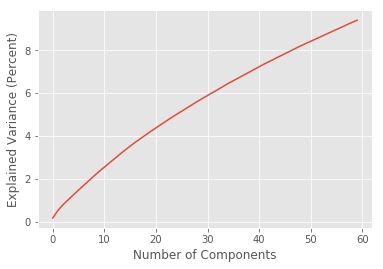

In [60]:
## FIGURE OUT HOW MANY COMPONENTS TO USE

plt.plot(var1)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance (Percent)")

In [61]:
print(lsa_tfidf_data.shape)
print(lsa_tfidf_data)

(6304, 60)
[[ 0.07199463 -0.00732347 -0.00781847 ... -0.04754543  0.01310103
  -0.02041514]
 [ 0.02221388 -0.00760748 -0.00370061 ...  0.01183303 -0.01105943
  -0.00398297]
 [ 0.04767324 -0.00888628 -0.00732754 ... -0.00332595  0.01833128
   0.00081649]
 ...
 [ 0.02417207 -0.00316024 -0.00257013 ...  0.00467858 -0.0095639
   0.02446644]
 [ 0.08033284  0.0363317  -0.0061627  ... -0.00043524 -0.0134633
   0.00803237]
 [ 0.02417207 -0.00316024 -0.00257013 ...  0.00467858 -0.0095639
   0.02446644]]


In [62]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lsa_tfidf_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.011s...
[t-SNE] Computed neighbors for 6304 samples in 3.675s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 82.303345
[t-SNE] Error after 1000 iterations: 1.877479


(6304, 2)

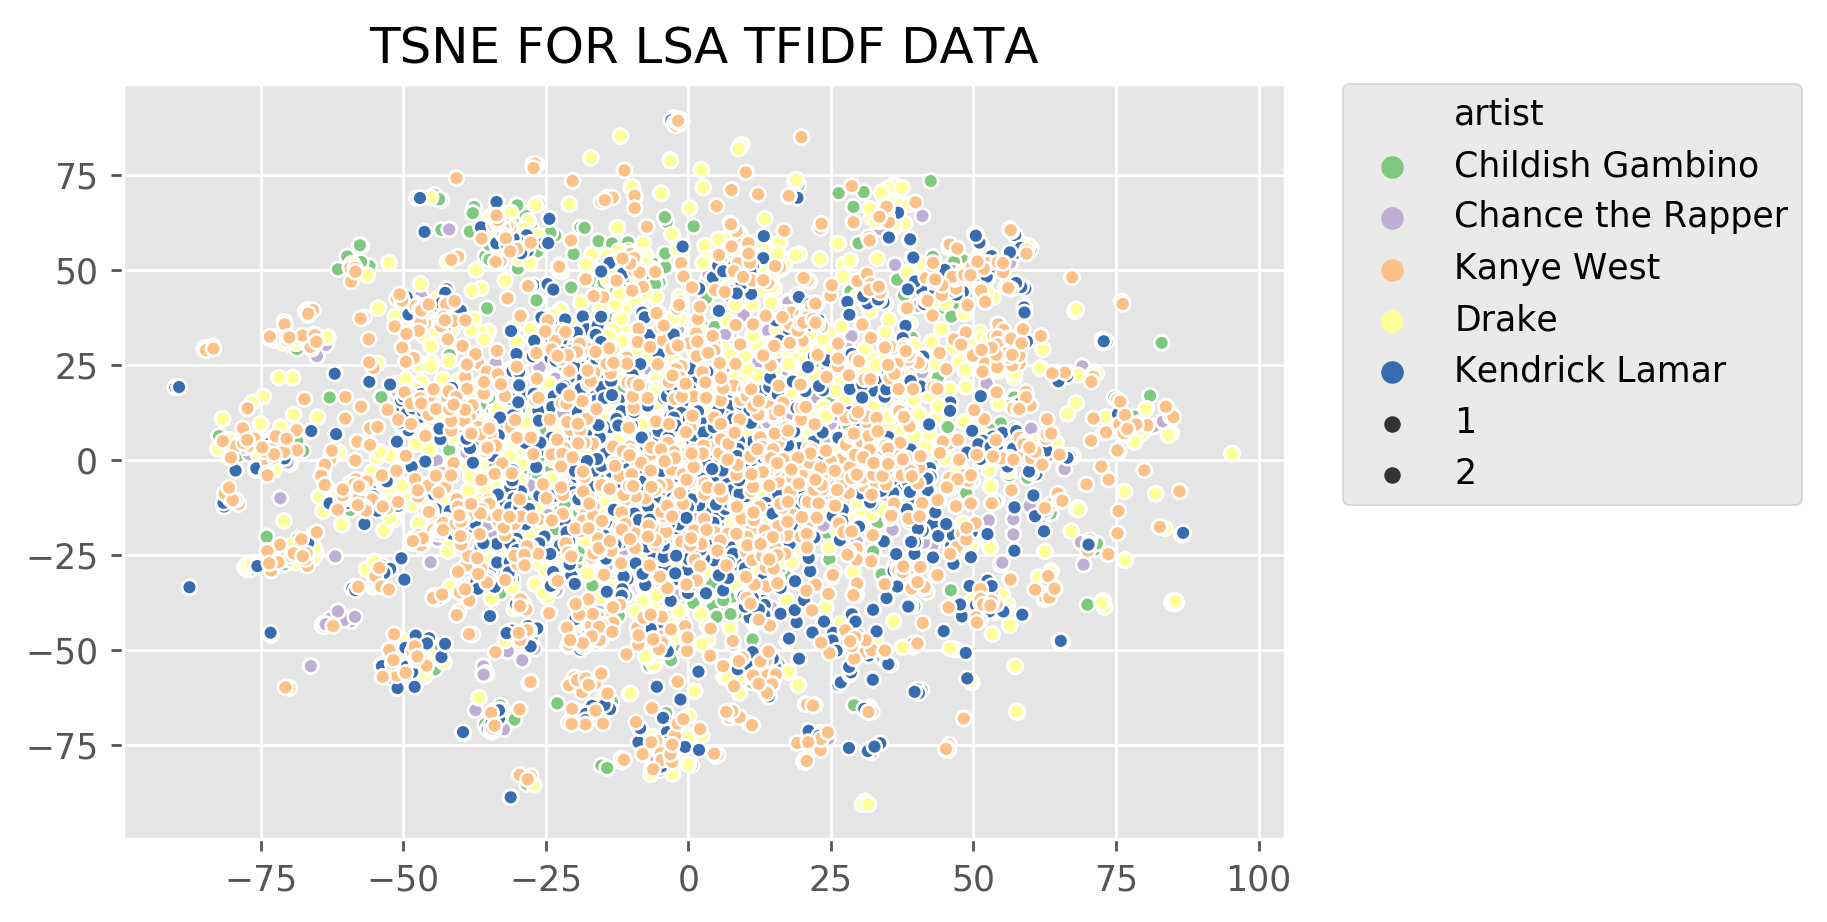

In [63]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LSA TFIDF DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [64]:
artists.value_counts()

Kanye West           1933
Drake                1596
Kendrick Lamar       1483
Childish Gambino      824
Chance the Rapper     468
Name: artist, dtype: int64

In [65]:
# nmf_cv DIMENSIONALITY REDUCTION ON CV
# Make the other two

n_comp = 40
nmf_cv = NMF(n_components=n_comp)

nmf_cv_data = nmf_cv.fit_transform(cv_data)
rapper = model_df.rapper

display_topics(nmf_cv,count_vectorizer.get_feature_names(),15)


Topic  0
say, say say, think, play, best, lucy, live, use, mean, people, life, hold, everybody, talk, city

Topic  1
ring, ring ring, hugh, buzzer, ring buzzer, hugh ring, buzzer hugh, hugh hugh, buzzer ring, chance, chance ring, ring chance, things, guess, thing

Topic  2
love, love love, wan love, love wan, ove, ove love, lo, love lo, lo ove, wan, say love, better, complicate, hurt, love say

Topic  3
cam, cam cam, ta cam, cam ta, ta, lotta, cam lotta, lotta ta, kanye west, west, kanye, ft, money money, remember, mark

Topic  4
wan, wan wan, mo, mo mo, mo wan, wan mo, wan love, love wan, everybody, mama, wa wan, wan wa, wa, really, everybody wan

Topic  5
juke, juke juke, break, town, chi, chi town, break chi, town break, break break, juke break, break juke, angel, live, mami, goin

Topic  6
need, need need, hand, work, clap, need right, yeezy, drop, clap hand, ve, ma, matter, check, million, bad bitch

Topic  7
man, black, black man, man let, man man, let man, man black, money blac

In [66]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=30).fit_transform(nmf_cv_data)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.066s...
[t-SNE] Computed neighbors for 6304 samples in 2.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.024818
[t-SNE] Error after 1000 iterations: 1.413874


(6304, 2)

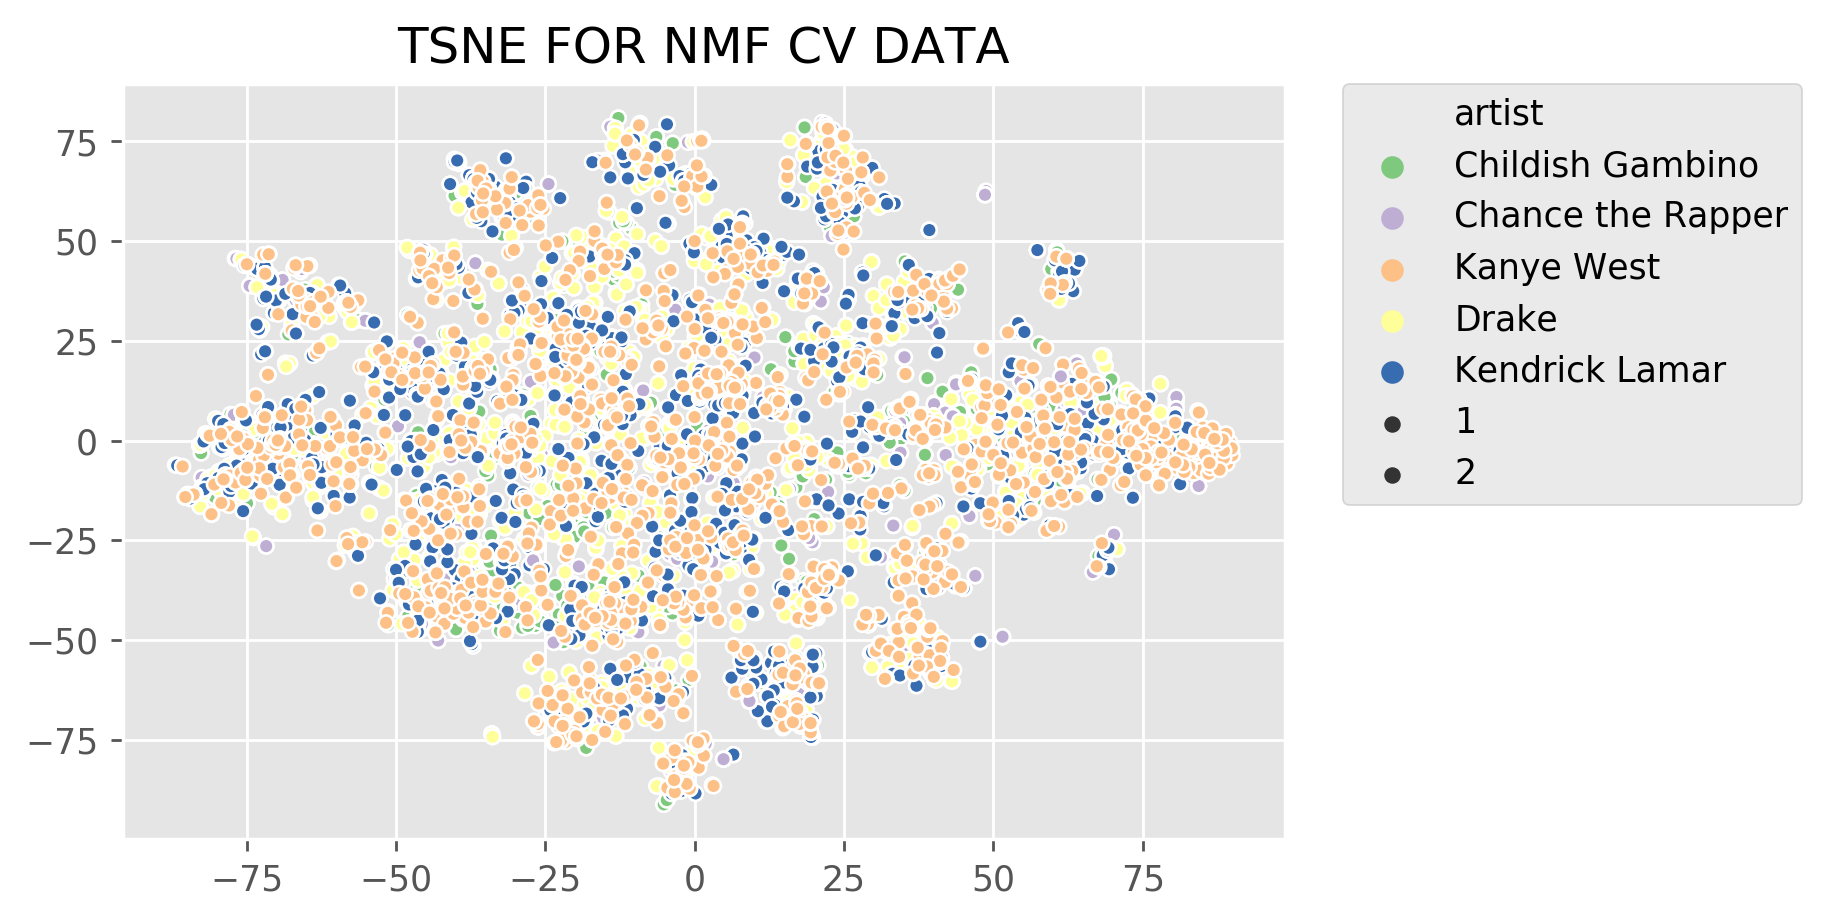

In [67]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR NMF CV DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [68]:
# lsa_cv DIMENSIONALITY REDUCTION ON CV

n_comp = 40
lsa_cv = TruncatedSVD(n_components=n_comp)

lsa_cv_data = lsa_cv.fit_transform(cv_data)

var_cv = lsa_cv.explained_variance_ratio_

var_cv1 = np.cumsum(np.round(lsa_cv.explained_variance_ratio_, decimals=4)*100)

display_topics(lsa_cv,count_vectorizer.get_feature_names(),15)


Topic  0
say, make, ai, love, tell, man, cause, need, time, wan, let, feel, ll, come, think

Topic  1
ring, ring ring, hugh, buzzer, ring buzzer, hugh ring, buzzer hugh, hugh hugh, buzzer ring, chance, ring chance, chance ring, things, guess, yo

Topic  2
love, love love, wan, wan love, love wan, wan wan, ove, ove love, love lo, lo ove, lo, say love, mo, complicate, love say

Topic  3
cam, cam cam, ta, ta cam, cam ta, love, lotta ta, cam lotta, lotta, love love, god, ft, kanye west, kanye, mark

Topic  4
wan, wan wan, mo, mo mo, wan mo, mo wan, wan love, everybody, love wan, mama, wan wa, wa wan, girl, wa, everybody wan

Topic  5
juke, juke juke, break, town, chi, chi town, town break, break chi, break break, juke break, break juke, wan, wan wan, gon, angel

Topic  6
need, need need, wan, right, wan wan, girl, hand, god, juke, juke juke, need right, clap, bad bitch, clap hand, yeezy

Topic  7
man, let, man let, black, need, let man, man man, black man, need need, money, man black, hal

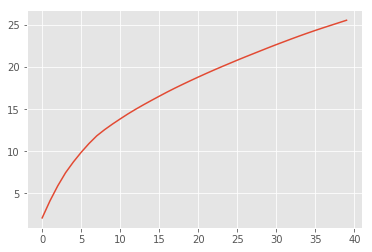

In [71]:
## FIGURE OUT HOW MANY COMPONENTS TO USE

plt.plot(var_cv1)

In [72]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lsa_cv_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.009s...
[t-SNE] Computed neighbors for 6304 samples in 3.862s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.185951
[t-SNE] Error after 1000 iterations: 1.570365


(6304, 2)

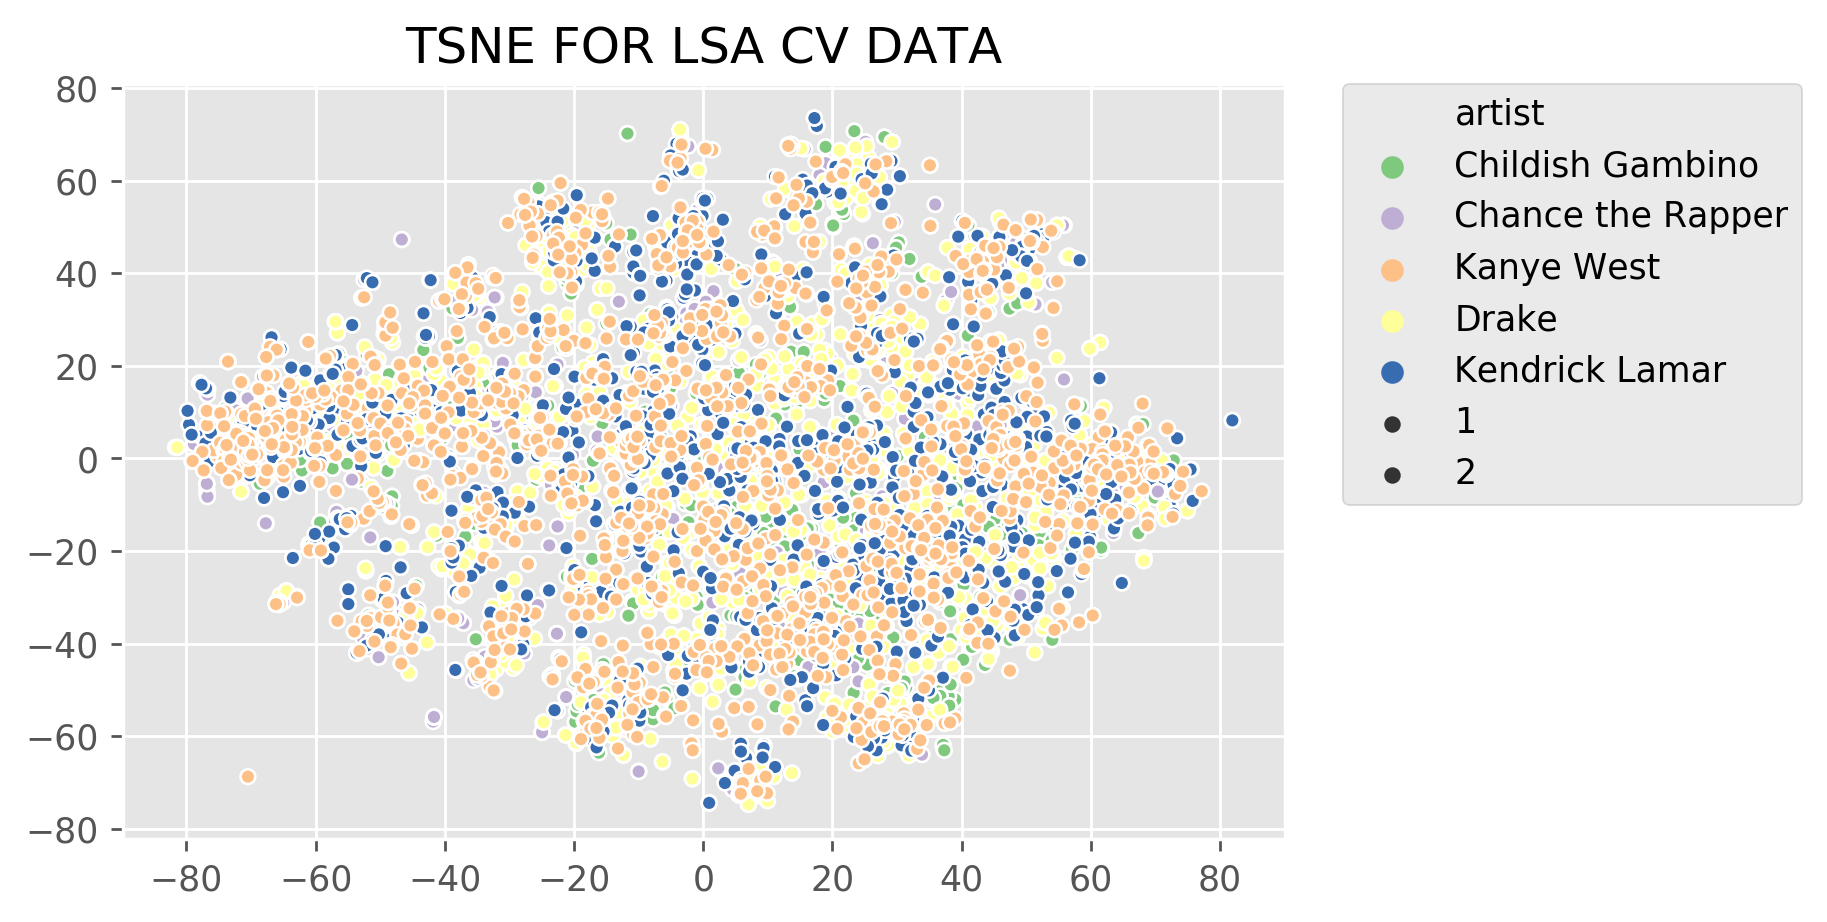

In [73]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LSA CV DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [74]:
## LDA WITH TFIDF

n_comp = 15
lda_tfidf = LatentDirichletAllocation(n_components=n_comp)

lda_tfidf_data = lda_tfidf.fit_transform(tfidf_data)

# var = lda_tfidf.explained_variance_ratio_

# var1 = np.cumsum(np.round(lda_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lda_tfidf,tfidf_vectorizer.get_feature_names(),15)


Topic  0
humming, fly past, graveshift ai, past sky, buy spaceship, wish buy, graveshift, workin graveshift, ve workin, spaceship fly, superhero, yawk, evet, god let, runnin rap

Topic  1
nanananana, rosie, sunshine, right til, til hold, rainbows, damn kanye, smile rosie, rosie come, aaaa, star damn, kanye car, rainbows sunshine, bir, terrify

Topic  2
talm, talm bout, bout talm, sun ll, remember perfect, perfect mistake, ll risin, risin til, hello mornin, risin, piff, act act, corny, let baby, act strange

Topic  3
away southside, southside serenade, serenade, serenade away, kendrick lamar, lamar, ayyy, blaow, turn wan, serenade south, directed, shine throw, ayyy ayyy, glitch, throw yo

Topic  4
say, love, make, tell, man, right, ai, let, time, feel, wan, cause, ca, ll, come

Topic  5
maine, slow motion, ca speak, feel understand, hope catch, kiss bathroom, baby baddest, ready heartbeat, heartbeat heartbeat, speak ca, heartbeat ca, spin spin, till money, person feel, brother sister



In [75]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lda_tfidf_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.005s...
[t-SNE] Computed neighbors for 6304 samples in 0.394s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.064583
[t-SNE] Error after 1000 iterations: 0.305799


(6304, 2)

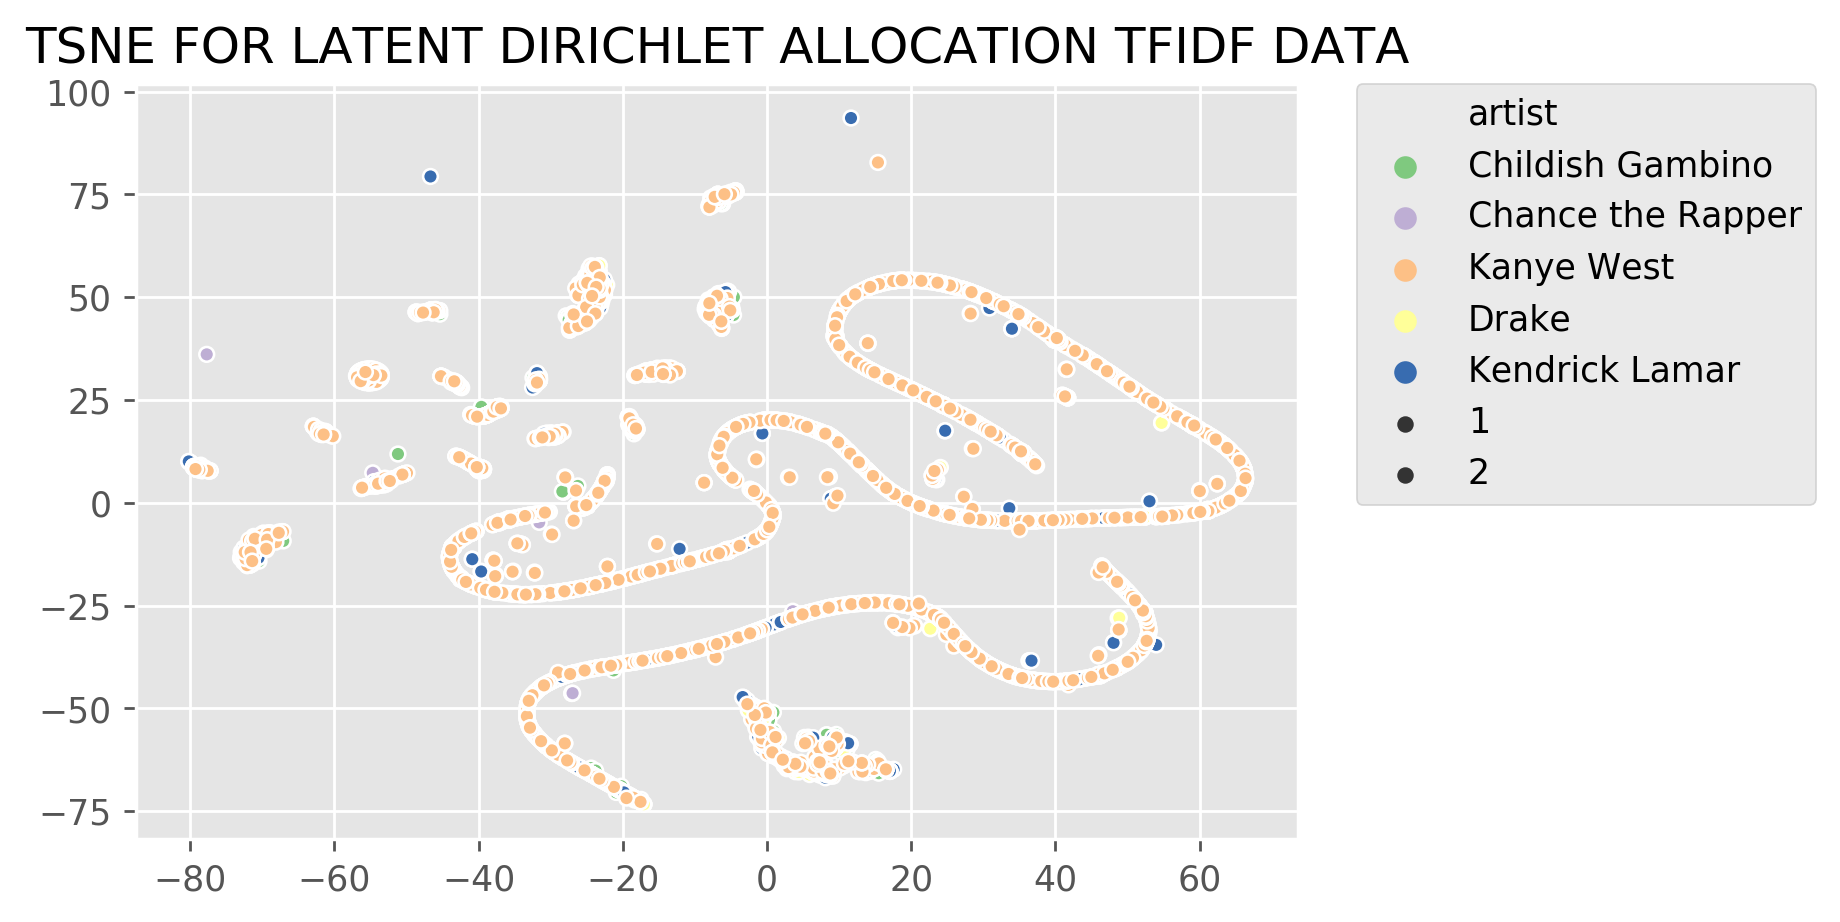

In [76]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LATENT DIRICHLET ALLOCATION TFIDF DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [77]:
## LDA WITH CV

n_comp = 15
lda_cv = LatentDirichletAllocation(n_components=n_comp)

lda_cv_data = lda_cv.fit_transform(cv_data)

# var = lda_tfidf.explained_variance_ratio_

# var1 = np.cumsum(np.round(lda_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lda_cv,count_vectorizer.get_feature_names(),15)


Topic  0
compton, party, impossible, south south, controlla, dna, visit, goose, spinnin, impossible impossible, controlla controlla, compton compton, rosecrans, cape, dice

Topic  1
gon, say say, fall, drink, forever, wake, better, wee, eye, wee wee, whoop, morning, dream, love better, close

Topic  2
hol, look, livin, explain, hol hol, ai ta, yah, ta, look look, juice, police, king, lil, blue, deserve

Topic  3
say, make, ai, tell, time, cause, man, right, come, ll, wan, bitch, ca, think, way

Topic  4
jump, yeezy, fore, igh, level, yeezy yeezy, motion, homies, chain heavy, heavy chain, dedicate, igh igh, outta, grant, slow motion

Topic  5
hold, wall, best best, love way, dive, best, pool liquor, th, remember, suicide, ai make, liquor dive, pair, matter, hold hold

Topic  6
brain, cells, brain cells, burn, linda, yeezy, issue, bout, burn brain, weeks, henny, cells burn, flame, funk, scratch

Topic  7
bout, jam, blow, aye, catch, ma, talm, girl head, blow blow, jam bout, bout jam, ta

### TOPIC 0: brain cells??

let, gon, wake, fall, kendrick, brain, let let, cells, brain cells, best best, stand, burn, lamar, kendrick lamar, weather

### TOPIC 1: LOVE

love, feel, say, good, way, make, better, love love, hold, leave, time, say say, come, ve, ll

### TOPIC 2: GOD/(LIQUOR+MUSIC+CAMERA)

need, god, need need, new, highlight, god god, brand, brand new, watch, swear, music, swear god, camera, pool liquor, blue

### TOPIC 3: black man/aggressive?

man, black, kanye, south, money, west, kanye west, black man, yea, shut, somebody, man man, type, sayin, wack

### TOPIC 4: friends/forever.

friends friends, ho, forever forever, zoom, weave, ho ho, zoom zoom, ta lie, planet, scratch, sunshine, west, throw diamonds, dream, wrong things

### TOPIC 5: movement

alright, cam, cam cam, light, shoot, motion, stand, drive slow, light light, slow homie, jesus walk, ca study, roll, flame, suit

### TOPIC 6: smoking/women

hol, juke, juke juke, hol hol, smoke, beyonce, controlla, compton, emotional, spin, break break, make right, controlla controlla, butter, lil bitch

### TOPIC 7: music/rap

jam, boy, bout, problem, rap, dj, cause, compton, blow, yah, ai, boo, level, low, blow blow

### TOPIC 8: very generic

say, tell, ai, make, cause, time, right, man, wan, bitch, ca, come, ll, look, think

### TOPIC 9: talking/sky/crash

bout, aye, continue, talm, team, talm bout, th, bout talm, touch sky, bitch ass, ooooh continue, levitate, crash, mhm, dice

### TOPIC 10: fun/summer/birthday/laugh

ring ring, summer, finna, yo, prolly, say time, better love, birthday, influence, june, conflict, laugh, ll prolly, click, cake

### TOPIC 11: girls/derogatory

baby, girl, started, amaze, extra, kill vibe, team, bitch kill, lord, amaze amaze, party, forgive, money, wee, kill

### TOPIC 12: gangstas

bom, fu, bom bom, chain heavy, gangstas, red, heavy chain, dna, debt, people love, amen, close, fu fu, simmer, create

### TOPIC 13: relax

yeezy, gon alright, relax ll, question, yeezy yeezy, ll whack, impossible, igh, everyday, dive, whack relax, bounce, nori, igh igh, wonderful

### TOPIC 14: cops/america

high, wo, livin, away, woah, complicate, police, wo high, america, catch, movie, whoop, blah, cool, mark

In [78]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50, random_state=69).fit_transform(lda_cv_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6304 samples in 0.005s...
[t-SNE] Computed neighbors for 6304 samples in 0.998s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6304
[t-SNE] Computed conditional probabilities for sample 2000 / 6304
[t-SNE] Computed conditional probabilities for sample 3000 / 6304
[t-SNE] Computed conditional probabilities for sample 4000 / 6304
[t-SNE] Computed conditional probabilities for sample 5000 / 6304
[t-SNE] Computed conditional probabilities for sample 6000 / 6304
[t-SNE] Computed conditional probabilities for sample 6304 / 6304
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.815151
[t-SNE] Error after 1000 iterations: 0.444157


(6304, 2)

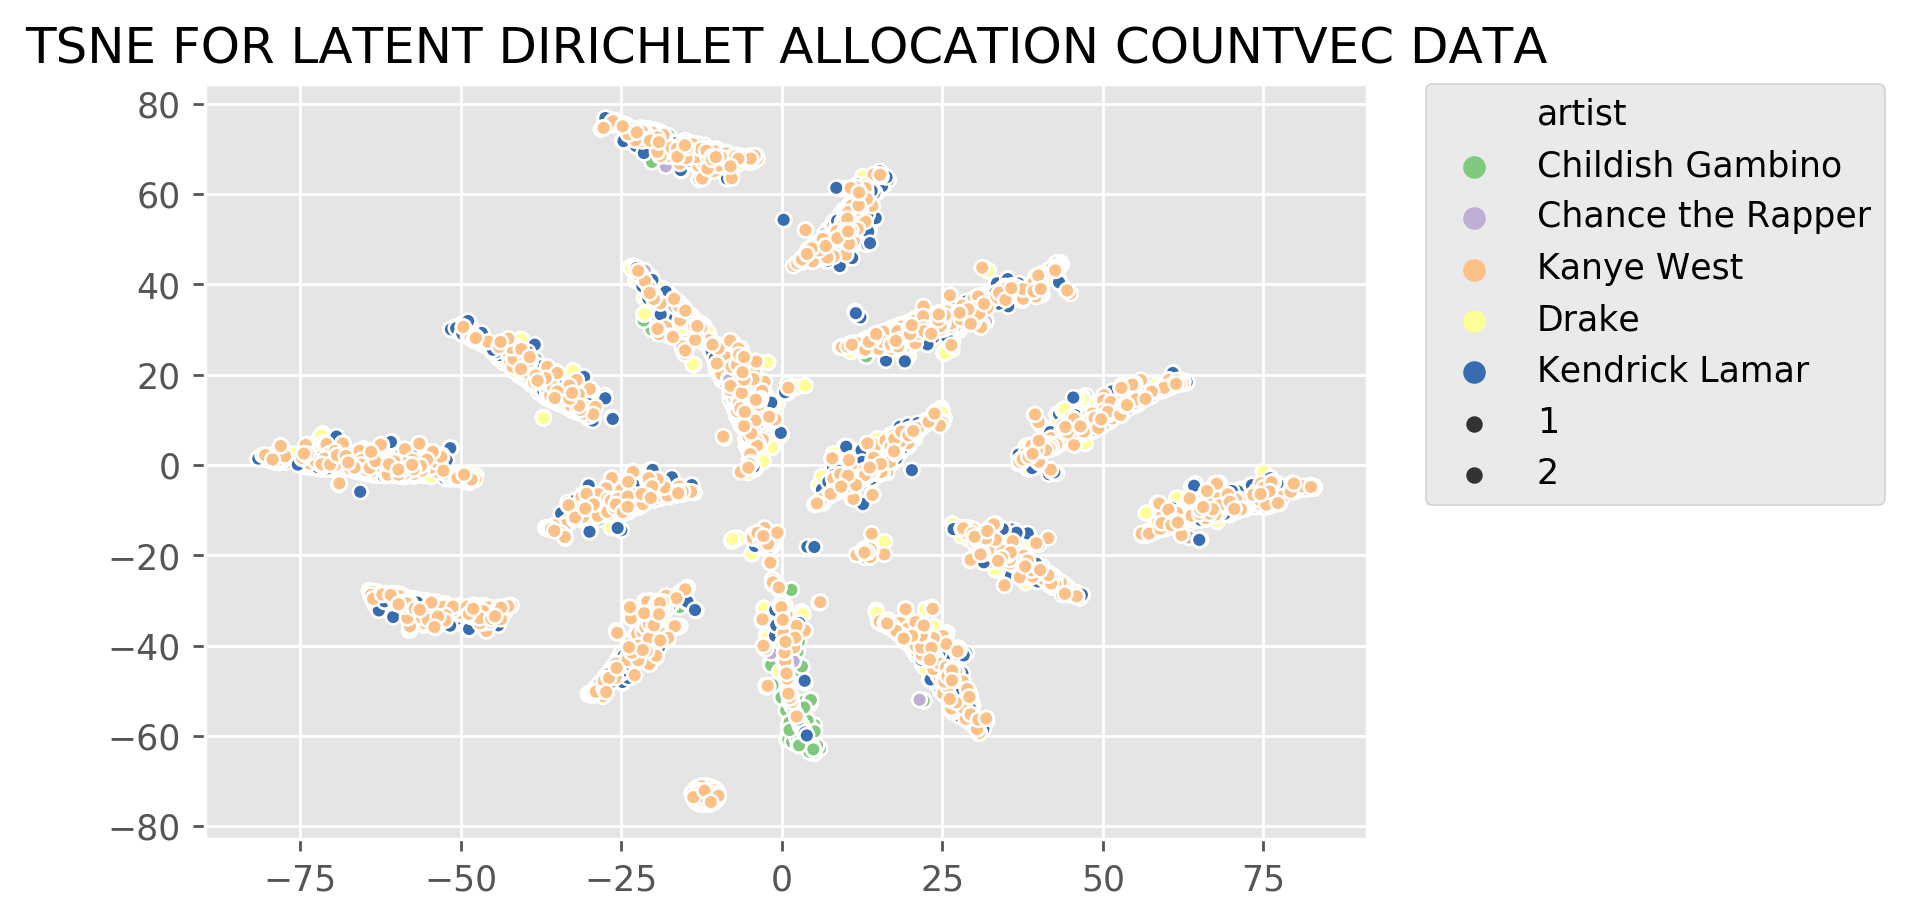

In [79]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LATENT DIRICHLET ALLOCATION COUNTVEC DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.savefig('/Users/brendenrossin/github/Project_Fletcher/TSNEartistlabeled.png', format='png', dpi=1000, bbox_inches="tight")


In [80]:
## PICKLE LDA ON CV_DATA SO YOU DON'T HAVE TO REFIT IT EACH TIME

with open('models/lda_cv_all_rappers.pkl', 'wb') as picklefile:
    pickle.dump(lda_cv, picklefile)

In [81]:
with open('data/lda_cv_data_all_rappers.pkl', 'wb') as picklefile:
    pickle.dump(lda_cv_data, picklefile)

In [82]:
## PICKLE TRUNCATED SVD ON TFIDF_DATA SO YOU DON'T HAVE TO REFIT IT EACH TIME

# with open('models/lsa_tfidf.pkl', 'wb') as picklefile:
#     pickle.dump(lsa_tfidf, picklefile)

In [83]:
rec_list = get_recommendations(model_df.verse_lem[900], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
recommendations_correct(900,rec_list)

10.0

In [84]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
    percent_corr.append(recommendations_correct(i,rec_list))

In [85]:
percent_corr

[30.0,
 30.0,
 50.0,
 40.0,
 30.0,
 10.0,
 60.0,
 20.0,
 0.0,
 10.0,
 40.0,
 30.0,
 10.0,
 10.0,
 50.0,
 0.0,
 0.0,
 30.0,
 50.0,
 30.0,
 20.0,
 60.0,
 0.0,
 30.0,
 30.0,
 10.0,
 20.0,
 30.0,
 20.0,
 10.0,
 20.0,
 10.0,
 0.0,
 20.0,
 10.0,
 10.0,
 0.0,
 60.0,
 20.0,
 10.0,
 10.0,
 30.0,
 0.0,
 50.0,
 10.0,
 50.0,
 20.0,
 50.0,
 0.0,
 20.0,
 0.0,
 20.0,
 0.0,
 20.0,
 0.0,
 20.0,
 0.0,
 40.0,
 40.0,
 20.0,
 10.0,
 20.0,
 20.0,
 40.0,
 30.0,
 40.0,
 20.0,
 40.0,
 50.0,
 10.0,
 0.0,
 10.0,
 10.0,
 0.0,
 50.0,
 0.0,
 30.0,
 20.0,
 0.0,
 40.0,
 10.0,
 0.0,
 20.0,
 10.0,
 20.0,
 0.0,
 20.0,
 0.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 50.0,
 10.0,
 50.0,
 0.0,
 50.0,
 40.0,
 50.0,
 20.0,
 10.0,
 40.0,
 50.0,
 60.0,
 10.0,
 60.0,
 10.0,
 20.0,
 30.0,
 40.0,
 20.0,
 20.0,
 40.0,
 20.0,
 10.0,
 30.0,
 20.0,
 30.0,
 10.0,
 0.0,
 20.0,
 20.0,
 20.0,
 50.0,
 20.0,
 20.0,
 20.0,
 30.0,
 30.0,
 0.0,
 0.0,
 30.0,
 0.0,
 20.0,
 40.0,
 0.0,
 40.0,
 40.0,
 30.0,
 10.0,
 30.0,
 0.0,
 0.0,
 30.0,
 20.0,
 40.0

In [86]:
sum(percent_corr)/len(percent_corr)

31.821065989847718

In [87]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lsa_tfidf, tfidf_vectorizer, lsa_tfidf_data)
    percent_corr.append(recommendations_correct(i,rec_list))

In [88]:
sum(percent_corr)/len(percent_corr)

39.703362944162436

In [90]:
# percent_corr = []

# for i in range(len(model_df)):
#     rec_list = get_recommendations(model_df.verse_lem[i], lsa_cv, count_vectorizer, lsa_cv_data)
#     percent_corr.append(recommendations_correct(i,rec_list))

In [91]:
# sum(percent_corr)/len(percent_corr)

In [92]:
# percent_corr = []

# for i in range(len(model_df)):
#     rec_list = get_recommendations(model_df.verse_lem[i], nmf_cv, count_vectorizer, nmf_cv_data)
#     percent_corr.append(recommendations_correct(i,rec_list))

In [93]:
# sum(percent_corr)/len(percent_corr)

In [94]:
# percent_corr = []

# for i in range(len(model_df)):
#     rec_list = get_recommendations(model_df.verse_lem[i], lda_cv, count_vectorizer, lda_cv_data)
#     percent_corr.append(recommendations_correct(i,rec_list))

In [95]:
# sum(percent_corr)/len(percent_corr)

In [96]:
# lsa_tfidf DIMENSIONALITY REDUCTION ON TFIDF

n_comp = [5,10,20,40,60]
print('USING LSA TFIDF')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lsa_tfidf = TruncatedSVD(n_components=i)

    lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lsa_tfidf, tfidf_vectorizer, lsa_tfidf_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING LSA TFIDF
Percent recommendations with correct artist using 5 components:  31.738578680203045


KeyboardInterrupt: 

In [ ]:
n_comp = [5,10,20,40,60]
print('USING LSA CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lsa_cv = TruncatedSVD(n_components=i)

    lsa_cv_data = lsa_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lsa_cv, count_vectorizer, lsa_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
                            
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

In [ ]:
n_comp = [5,10,20,40,60]
print('USING NMF CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    nmf_cv = NMF(n_components=i)

    nmf_cv_data = nmf_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], nmf_cv, count_vectorizer, nmf_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

In [ ]:
n_comp = [2,5,8,10,12,15]
print('USING LDA CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lda_cv = LatentDirichletAllocation(n_components=i)

    lda_cv_data = lda_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lda_cv, count_vectorizer, lda_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

In [98]:
n_comp = [2,5,8,10,12,15]
print('USING LDA TFIDF')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lda_tfidf = LatentDirichletAllocation(n_components=i)

    lda_tfidf_data = lda_tfidf.fit_transform(tfidf_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING LDA TFIDF
Percent recommendations with correct artist using 2 components:  28.74524111675127


KeyboardInterrupt: 

Childish Gambino: 1933
Chance: 1596
Proportion: 1.21 : 1
Percentage of Majority Class: 30.659999999999997


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

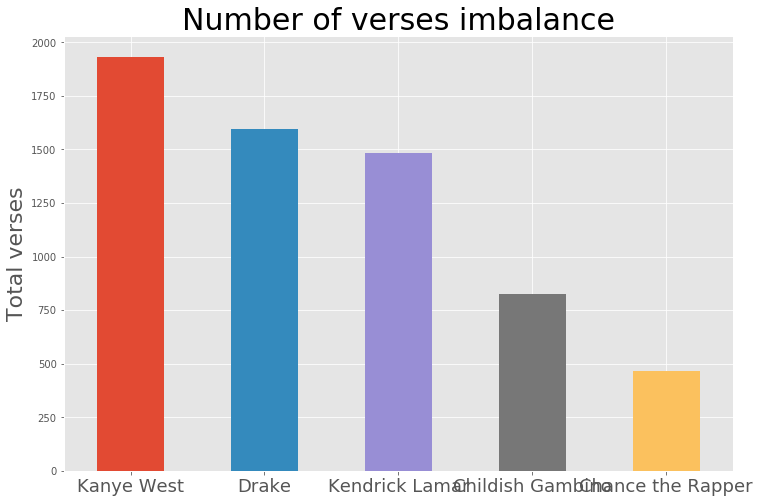

In [100]:
target_count = model_df['artist'].value_counts()
print(f'Childish Gambino: {target_count[0]}')
print(f'Chance: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

target_count.plot(kind='bar', title='Artist Count', rot=0);
plt.gcf().set_size_inches(12,8)
plt.ylabel('Total verses', fontsize=22)
plt.title("Number of verses imbalance", fontsize=30)
plt.xticks(fontsize=18)

In [101]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(model_df, test_size=0.2, random_state=42)

In [213]:
x_train = train_data.verse_lem
y_train = train_data.artist


x_test = test_data.verse_lem
y_test = test_data.artist

In [103]:
x_train[:5]

6055    But I don ’ t even wan na hit on you , don ’ t...
2347    Why you over there lookin at me , While your m...
2098    Uhh , yeah , This be really one of my dumbest ...
5673    Homie check it out I get her mesmerize , So wo...
5679    Now the Chocolate Factory be what I bump in my...
Name: verse_lem, dtype: object

In [104]:
print(y_train[:5])

6055    Kanye West
2347         Drake
2098         Drake
5673    Kanye West
5679    Kanye West
Name: artist, dtype: object


NameError: name 'grid' is not defined

In [106]:
models = [LogisticRegression(), KNeighborsClassifier(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), DummyClassifier()]
names = ['LR', 'KNN', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees', 'Dummy']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train_index, test_index in kf.split(x_train):
        
        kX_train = x_train.iloc[train_index]
        kX_test = x_train.iloc[test_index]
        ky_train = y_train.iloc[train_index]
        ky_test = y_train.iloc[test_index]
        
        model = Pipeline([('tfid', TfidfVectorizer()), ('LSA', TruncatedSVD()), (names[i], models[i])])
        #fit it to my data 
        model.fit(kX_train, ky_train)
        y_train_pred = model.predict(kX_train)

        accuracy.append(accuracy_score(ky_train, y_train_pred))
        precision.append(precision_score(ky_train, y_train_pred, average=None))
        recall.append(recall_score(ky_train, y_train_pred, average=None))
        f1.append(f1_score(ky_train, y_train_pred, average=None))

    model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()
    
    model_score = np.round(model_score, 4)
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    
    print('Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION')
    print(f'{names[i]} model_score: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
LR model_score: 0.3471 accuracy: 0.3463 precision: 0.1572 recall: 0.2416 f1: 0.1782

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
KNN model_score: 0.3409 accuracy: 0.5501 precision: 0.5249 recall: 0.5164 f1: 0.5172

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
SVC model_score: 0.3555 accuracy: 0.3552 precision: 0.1537 recall: 0.2445 f1: 0.1769

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Decision Tree model_score: 0.3947 accuracy: 0.9966 precision: 0.9975 recall: 0.9957 f1: 0.9966

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Random Forest model_score: 0.4022 accuracy: 0.9719 precision: 0.9736 recall: 0.9699 f1: 0.9717

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Gradient Boosted Trees model_score: 0.3754 accuracy: 0.5435 precision: 0.701 recall: 0.457 f1: 0.4828

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Dummy model_score: 0.2296 accuracy:

In [107]:
models = [('tree', DecisionTreeClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60],
                  'tree__max_depth': [1,2,3,4,5,6,7], 'tree__min_samples_leaf': [3,6,8,10,12,15]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.3999603410668253, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


In [108]:
dt1 = grid.best_estimator_
dt1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [109]:
model = dt1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('DECISION TREE MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

DECISION TREE MVP
modelscore: 0.3825 accuracy: 0.5175 precision: 0.5264 recall: 0.4341 f1: 0.4426



In [110]:
models = [('LogReg', LogisticRegression)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60], 'LogReg__C': np.logspace(-3,6, 12)}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

LogReg: best score: 0.45746579417013683, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


In [111]:
lm1 = grid.best_estimator_
lm1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [112]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = lm1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(lm1, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('Logistic Regress MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

Logistic Regress MVP
modelscore: 0.4596 accuracy: 0.4866 precision: 0.5224 recall: 0.3949 f1: 0.4019



In [113]:
models = [('forest', RandomForestClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60],
                  'forest__n_estimators': [25,50, 100, 200], 'forest__max_depth': [1,2,3,4,5,7,10],
                  'forest__min_samples_leaf': [3,6,10]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.553837001784652, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [114]:
rf1 = grid.best_estimator_
rf1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [115]:
model = rf1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('RANDOM FOREST ALL RAPPERS')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

RANDOM FOREST ALL RAPPERS
modelscore: 0.5408 accuracy: 0.8362 precision: 0.9018 recall: 0.7247 f1: 0.7566



In [116]:
models = [('knn', KNeighborsClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60],
                  'knn__n_neighbors': range(1, 12)}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.5387666071782669, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])


In [117]:
knn1 = grid.best_estimator_
knn1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])

In [118]:
model = knn1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('K-NEAREST NEIGHBORS ALL RAPPERS')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

K-NEAREST NEIGHBORS ALL RAPPERS
modelscore: 0.5027 accuracy: 0.9837 precision: 0.9876 recall: 0.9823 f1: 0.9847



In [119]:
from sklearn.metrics import confusion_matrix

model = lm1

predict_y_train = model.predict(x_train)

LR_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on LogReg model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_train, predict_y_train)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

The mean of 10 fold cross validation accuracy score on LogReg model is 0.451


ValueError: Shape of passed values is (5, 5), indices imply (2, 2)

In [ ]:
from sklearn.metrics import confusion_matrix

model = rf1

predict_y_train = model.predict(x_train)

RF_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF = confusion_matrix(y_train, predict_y_train)
RF_CM = print_confusion_matrix(RF, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
from sklearn.metrics import confusion_matrix

model = knn1

predict_y_train = model.predict(x_train)

KNN_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on KNN model is', str(round(np.mean(KNN_cross_val), 3)))

KNN = confusion_matrix(y_train, predict_y_train)
KNN_CM = print_confusion_matrix(KNN, ['Chance The Rapper', 'Childish Gambino'])

In [120]:
models = [('dc', DummyClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

dc: best score: 0.24826492167360698, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...e=None, tol=0.0)), ('dc', DummyClassifier(constant=None, random_state=None, strategy='stratified'))])


In [121]:
dc = grid.best_estimator_
dc.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...e=None, tol=0.0)), ('dc', DummyClassifier(constant=None, random_state=None, strategy='stratified'))])

In [122]:
models = [('knn', KNeighborsClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.4463612928812215, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])


In [123]:
knn2 = grid.best_estimator_
knn2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [124]:
models = [('RF', RandomForestClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

RF: best score: 0.5272655165576046, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [125]:
rf2 = grid.best_estimator_
rf2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [126]:
model = rf2

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('RANDOM FOREST NO TUNING ALL RAPPERS')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

RANDOM FOREST NO TUNING ALL RAPPERS
modelscore: 0.5006 accuracy: 0.9812 precision: 0.9859 recall: 0.978 f1: 0.9818



In [127]:
models = [('tree', DecisionTreeClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LSA', TruncatedSVD()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LSA__n_components': [20,40,60]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.48205433273844933, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


In [128]:
dt2 = grid.best_estimator_
dt2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [129]:
model = dt2

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, average=None))
    recall.append(recall_score(ky_test, y_predict, average=None))
    f1.append(f1_score(ky_test, y_predict, average=None))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('Decision Tree NO TUNING ALL RAPPERS')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

Decision Tree NO TUNING ALL RAPPERS
modelscore: 0.4637 accuracy: 0.9877 precision: 0.9906 recall: 0.9853 f1: 0.9878



In [130]:
models = [lm1, rf1, knn1, dc, knn2, dt1, rf2, dt2]
names = ['LogReg', 'Random Forest', 'KNN', 'Dummy', 'KNN2', 'Decision Tree', 'RF2', 'DT2']

print(f'TEST Scores ALL RAPPERS')

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []

    y_predict = model.predict(x_test)

    accuracy.append(accuracy_score(y_test, y_predict))
    precision.append(precision_score(y_test, y_predict, average=None))
    recall.append(recall_score(y_test, y_predict, average=None))
    f1.append(f1_score(y_test, y_predict, average=None))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)


    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

TEST Scores ALL RAPPERS
LogReg accuracy: 0.4615 precision: 0.5079 recall: 0.3745 f1: 0.3769

Random Forest accuracy: 0.5797 precision: 0.7399 recall: 0.4828 f1: 0.4953

KNN accuracy: 0.5702 precision: 0.5502 recall: 0.5483 f1: 0.5478

Dummy accuracy: 0.23 precision: 0.1905 recall: 0.192 f1: 0.191

KNN2 accuracy: 0.4726 precision: 0.4418 recall: 0.4511 f1: 0.4443

Decision Tree accuracy: 0.3981 precision: 0.3941 recall: 0.3317 f1: 0.3298

RF2 accuracy: 0.5654 precision: 0.5674 recall: 0.5227 f1: 0.5377

DT2 accuracy: 0.4925 precision: 0.4699 recall: 0.4739 f1: 0.4716



In [131]:
models = [lm1, rf2, knn2, dt2, dc]
names = ['LogReg', 'Random Forest', 'KNN', 'Decision Tree', 'Dummy']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(x_train, y_train)
    preds = model.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label = 'Childish Gambino')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 ...
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]]


Text(0.5,1,'Comparing ROC Curves')

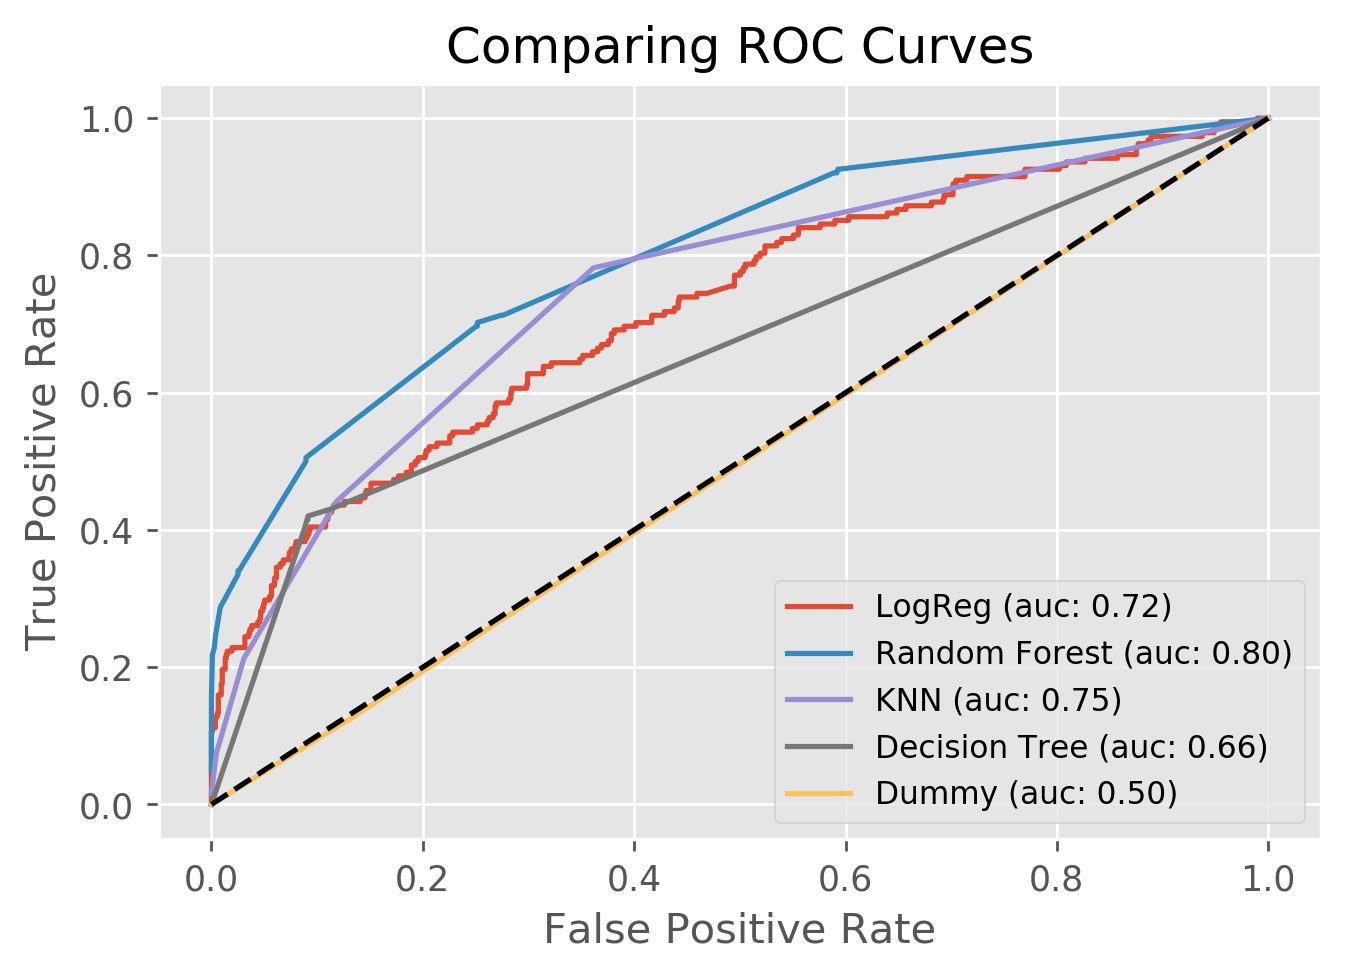

In [132]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves")

In [133]:
model = rf1

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on RF1 model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

The mean of 10 fold cross validation accuracy score on RF1 model is 0.43


ValueError: Shape of passed values is (5, 5), indices imply (2, 2)

In [217]:
def print_confusion_matrix_real(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(dpi=250)
    plt.title("Verse text classification (RF)", fontsize=16)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig('/Users/brendenrossin/github/Project_Fletcher/RF_cm.png', format='png', dpi=1000, bbox_inches="tight")
    return fig

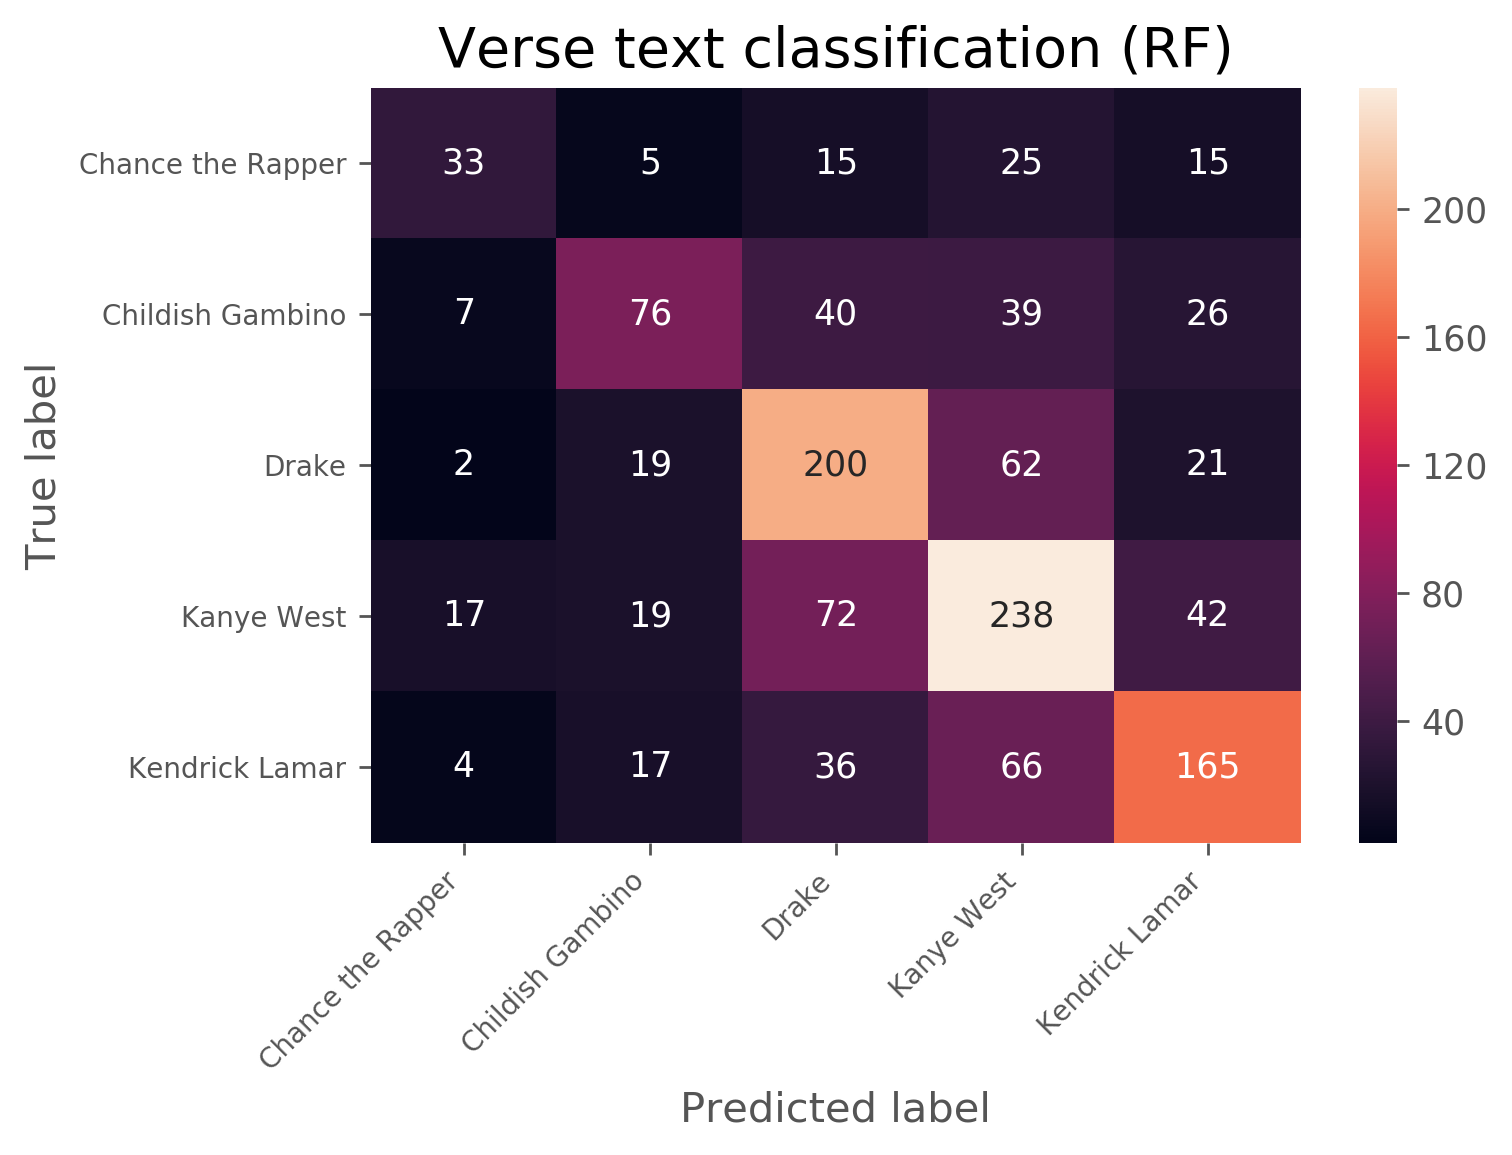

In [218]:
model = rf2

predict_y_test = model.predict(x_test)

RF = confusion_matrix(y_test, predict_y_test)
RF_CM = print_confusion_matrix_real(RF, ['Chance the Rapper', 'Childish Gambino', 'Drake', 'Kanye West', 'Kendrick Lamar'])

In [ ]:
model = dt2

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on DecisionTree 2 model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
model = dc

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on Dummy model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

In [134]:
with open('models/allartists_RF.pkl', 'wb') as picklefile:
    pickle.dump(rf2, picklefile)
    
with open('models/allartists_LogReg.pkl', 'wb') as picklefile:
    pickle.dump(lm1, picklefile)
    
with open('models/allartists_KNN.pkl', 'wb') as picklefile:
    pickle.dump(knn2, picklefile)
    
with open('models/allartists_DecTree.pkl', 'wb') as picklefile:
    pickle.dump(dt2, picklefile)
    
with open('models/allartists_Dummy.pkl', 'wb') as picklefile:
    pickle.dump(dc, picklefile)

In [155]:
with open('data/kendrick_generated_raps.pkl', 'rb') as picklefile:
    kendrick_generated_df = pickle.load(picklefile)
    
with open('data/all_rappers_generated_raps.pkl', 'rb') as picklefile:
    all_rappers_generated_df = pickle.load(picklefile)
    
with open('data/childish_generated_raps.pkl', 'rb') as picklefile:
    childish_generated_df = pickle.load(picklefile)
    
with open('data/chance_generated_raps.pkl', 'rb') as picklefile:
    chance_generated_df = pickle.load(picklefile)
    
with open('data/drake_generated_raps.pkl', 'rb') as picklefile:
    drake_generated_df = pickle.load(picklefile)
    
with open('data/kanye_generated_raps.pkl', 'rb') as picklefile:
    kanye_generated_df = pickle.load(picklefile)

In [156]:
frames = [kendrick_generated_df, all_rappers_generated_df, childish_generated_df, chance_generated_df,
          drake_generated_df, kanye_generated_df]

generated_verses_df = pd.concat(frames)

generated_verses_df.reset_index(inplace=True)

In [157]:
generated_verses_df.artist.value_counts()

Childish Gambino     23
Drake                23
Chance the Rapper    23
Combined             23
Kendrick Lamar       23
Kanye West           23
Name: artist, dtype: int64

In [158]:
generated_verses_df

index                                   generated_verses          artist
0        0  I miss you girl come back to make you know you...  Kendrick Lamar
1        1  To be or not to be: and my song of my from the...  Kendrick Lamar
2        2  Started from the bottom a tist be for king and...  Kendrick Lamar
3        3  I'm the realest rapper alive i sing my dont th...  Kendrick Lamar
4        4  Smoke a lot of weed have back a had the can bu...  Kendrick Lamar
5        5  Baby come on the can had bout the parce the se...  Kendrick Lamar
6        6  Date a scientist and the song not and the borg...  Kendrick Lamar
7        7  Butter my biscuition the and how a sin coorder...  Kendrick Lamar
8        8  Scramble my sing so the flow me so who a compr...  Kendrick Lamar
9        9  I sleep a wait of king i m the she nigga it mo...  Kendrick Lamar
10      10  Green eggs and i compling what i be and to the...  Kendrick Lamar
11      11  Rollin in my sing my song i was dont me on my ...  Kendrick Lamar
12      12  Drop top a mink a song in the nigga i king i d...  Kendrick Lamar
13      13  Math is funk the pock that its me with the hom...  Kendrick Lamar
14      14  Sentencest i can can didnt know you king you w...  Kendrick Lamar
15      15  Coffee in the world king complead and i was an...  Kendrick Lamar
16      16  Table that can some it some a before that i go...  Kendrick Lamar
17      17  Homies my song i know what i the all get my sc...  Kendrick Lamar
18      18  From the streets to the contron when you dont ...  Kendrick Lamar
19      19  Maseratin that compton i can me of the world s...  Kendrick Lamar
20      20  Air force one me i want compton how you dont d...  Kendrick Lamar
21      21  President i veart and of that we bout on my si...  Kendrick Lamar
22      22  Trump dont dont i can but holled you can the s...  Kendrick Lamar
23       0  I miss you girl come back like the teal here a...        Combined
24       1  To be or not to be: in the can some what that ...        Combined
25       2  Started from the bottom a fall nigga never sid...        Combined
26       3  I'm the realest rapper alive and she and hold ...        Combined
27       4  Smoke a lot of weed of for the wrove that fall...        Combined
28       5  Baby come it though a like i dont the come tha...        Combined
29       6  Date a scientisten some real and of misters ma...        Combined
..     ...                                                ...             ...
108     16  Table that she feel yours it on like it you ne...           Drake
109     17  Homies the for me the clights thats more that ...           Drake
110     18  From the streets of and they still off and it ...           Drake
111     19  Maseration to playing something the break it s...           Drake
112     20  Air force one drake should people got a fuckin...           Drake
113     21  President like a little does better and that s...           Drake
114     22  Trump got be what not to got to dont gettin to...           Drake
115      0  I miss you girl come back that i to the wrock ...      Kanye West
116      1  To be or not to be: and to the class like off ...      Kanye West
117      2  Started from the bottom the round that you got...      Kanye West
118      3  I'm the realest rapper alive the be im the loo...      Kanye West
119      4  Smoke a lot of weed the be in the doubted that...      Kanye West
120      5  Baby come i got that that how you could me off...      Kanye West
121      6  Date a scientistant im go do i m screation we ...      Kanye West
122      7  Butter my biscuit me they want my stop i m day...      Kanye West
123      8  Scramble my cant off that that the bent i was ...      Kanye West
124      9  I sleep the way i know now the lost the please...      Kanye West
125     10  Green eggs and the clother was to get that to ...      Kanye West
126     11  Rollin in my contion the start and if i like a...      Kanye West
127     12  Drop top to me 

In [159]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

generated_verses_df['verse_lem'] = generated_verses_df["generated_verses"].apply(lambda x: [wordnet_lemmatizer.lemmatize(y, pos='v') for y in x])

In [160]:
generated_verses_df

index                                   generated_verses          artist  \
0        0  I miss you girl come back to make you know you...  Kendrick Lamar   
1        1  To be or not to be: and my song of my from the...  Kendrick Lamar   
2        2  Started from the bottom a tist be for king and...  Kendrick Lamar   
3        3  I'm the realest rapper alive i sing my dont th...  Kendrick Lamar   
4        4  Smoke a lot of weed have back a had the can bu...  Kendrick Lamar   
5        5  Baby come on the can had bout the parce the se...  Kendrick Lamar   
6        6  Date a scientist and the song not and the borg...  Kendrick Lamar   
7        7  Butter my biscuition the and how a sin coorder...  Kendrick Lamar   
8        8  Scramble my sing so the flow me so who a compr...  Kendrick Lamar   
9        9  I sleep a wait of king i m the she nigga it mo...  Kendrick Lamar   
10      10  Green eggs and i compling what i be and to the...  Kendrick Lamar   
11      11  Rollin in my sing my song i was dont me on my ...  Kendrick Lamar   
12      12  Drop top a mink a song in the nigga i king i d...  Kendrick Lamar   
13      13  Math is funk the pock that its me with the hom...  Kendrick Lamar   
14      14  Sentencest i can can didnt know you king you w...  Kendrick Lamar   
15      15  Coffee in the world king complead and i was an...  Kendrick Lamar   
16      16  Table that can some it some a before that i go...  Kendrick Lamar   
17      17  Homies my song i know what i the all get my sc...  Kendrick Lamar   
18      18  From the streets to the contron when you dont ...  Kendrick Lamar   
19      19  Maseratin that compton i can me of the world s...  Kendrick Lamar   
20      20  Air force one me i want compton how you dont d...  Kendrick Lamar   
21      21  President i veart and of that we bout on my si...  Kendrick Lamar   
22      22  Trump dont dont i can but holled you can the s...  Kendrick Lamar   
23       0  I miss you girl come back like the teal here a...        Combined   
24       1  To be or not to be: in the can some what that ...        Combined   
25       2  Started from the bottom a fall nigga never sid...        Combined   
26       3  I'm the realest rapper alive and she and hold ...        Combined   
27       4  Smoke a lot of weed of for the wrove that fall...        Combined   
28       5  Baby come it though a like i dont the come tha...        Combined   
29       6  Date a scientisten some real and of misters ma...        Combined   
..     ...                                                ...             ...   
108     16  Table that she feel yours it on like it you ne...           Drake   
109     17  Homies the for me the clights thats more that ...           Drake   
110     18  From the streets of and they still off and it ...           Drake   
111     19  Maseration to playing something the break it s...           Drake   
112     20  Air force one drake should people got a fuckin...           Drake   
113     21  President like a little does better and that s...           Drake   
114     22  Trump got be what not to got to dont gettin to...           Drake   
115      0  I miss you girl come back that i to the wrock ...      Kanye West   
116      1  To be or not to be: and to the class like off ...      Kanye West   
117      2  Started from the bottom the round that you got...      Kanye West   
118      3  I'm the realest rapper alive the be im the loo...      Kanye West   
119      4  Smoke a lot of weed the be in the doubted that...      Kanye West   
120      5  Baby come i got that that how you could me off...      Kanye West   
121      6  Date a scientistant im go do i m screation we ...      Kanye West   
122      7  Butter my biscuit me they want my stop i m day...      Kanye West   
123      8  Scramble my cant off that that the bent i was ...      Kanye West   
124      9  I sleep the way i know now the lost the please...      Kanye West   
125     10  Green eggs and the cloth

In [161]:
generated_verses_df['verse_lem'] = generated_verses_df['verse_lem'].apply(', '.join)
generated_verses_df['verse_lem'] = generated_verses_df['verse_lem'].apply(lambda x: x.replace(", ", " "))

In [162]:
generated_verses_df

index                                   generated_verses          artist  \
0        0  I miss you girl come back to make you know you...  Kendrick Lamar   
1        1  To be or not to be: and my song of my from the...  Kendrick Lamar   
2        2  Started from the bottom a tist be for king and...  Kendrick Lamar   
3        3  I'm the realest rapper alive i sing my dont th...  Kendrick Lamar   
4        4  Smoke a lot of weed have back a had the can bu...  Kendrick Lamar   
5        5  Baby come on the can had bout the parce the se...  Kendrick Lamar   
6        6  Date a scientist and the song not and the borg...  Kendrick Lamar   
7        7  Butter my biscuition the and how a sin coorder...  Kendrick Lamar   
8        8  Scramble my sing so the flow me so who a compr...  Kendrick Lamar   
9        9  I sleep a wait of king i m the she nigga it mo...  Kendrick Lamar   
10      10  Green eggs and i compling what i be and to the...  Kendrick Lamar   
11      11  Rollin in my sing my song i was dont me on my ...  Kendrick Lamar   
12      12  Drop top a mink a song in the nigga i king i d...  Kendrick Lamar   
13      13  Math is funk the pock that its me with the hom...  Kendrick Lamar   
14      14  Sentencest i can can didnt know you king you w...  Kendrick Lamar   
15      15  Coffee in the world king complead and i was an...  Kendrick Lamar   
16      16  Table that can some it some a before that i go...  Kendrick Lamar   
17      17  Homies my song i know what i the all get my sc...  Kendrick Lamar   
18      18  From the streets to the contron when you dont ...  Kendrick Lamar   
19      19  Maseratin that compton i can me of the world s...  Kendrick Lamar   
20      20  Air force one me i want compton how you dont d...  Kendrick Lamar   
21      21  President i veart and of that we bout on my si...  Kendrick Lamar   
22      22  Trump dont dont i can but holled you can the s...  Kendrick Lamar   
23       0  I miss you girl come back like the teal here a...        Combined   
24       1  To be or not to be: in the can some what that ...        Combined   
25       2  Started from the bottom a fall nigga never sid...        Combined   
26       3  I'm the realest rapper alive and she and hold ...        Combined   
27       4  Smoke a lot of weed of for the wrove that fall...        Combined   
28       5  Baby come it though a like i dont the come tha...        Combined   
29       6  Date a scientisten some real and of misters ma...        Combined   
..     ...                                                ...             ...   
108     16  Table that she feel yours it on like it you ne...           Drake   
109     17  Homies the for me the clights thats more that ...           Drake   
110     18  From the streets of and they still off and it ...           Drake   
111     19  Maseration to playing something the break it s...           Drake   
112     20  Air force one drake should people got a fuckin...           Drake   
113     21  President like a little does better and that s...           Drake   
114     22  Trump got be what not to got to dont gettin to...           Drake   
115      0  I miss you girl come back that i to the wrock ...      Kanye West   
116      1  To be or not to be: and to the class like off ...      Kanye West   
117      2  Started from the bottom the round that you got...      Kanye West   
118      3  I'm the realest rapper alive the be im the loo...      Kanye West   
119      4  Smoke a lot of weed the be in the doubted that...      Kanye West   
120      5  Baby come i got that that how you could me off...      Kanye West   
121      6  Date a scientistant im go do i m screation we ...      Kanye West   
122      7  Butter my biscuit me they want my stop i m day...      Kanye West   
123      8  Scramble my cant off that that the bent i was ...      Kanye West   
124      9  I sleep the way i know now the lost the please...      Kanye West   
125     10  Green eggs and the cloth

In [174]:
generated_verses_df.loc[generated_verses_df["artist"] == 'Childish Gambino', "rapper"] = '1'
generated_verses_df.loc[generated_verses_df["artist"] == 'Chance the Rapper', "rapper"] = '2'
generated_verses_df.loc[generated_verses_df["artist"] == 'Drake', "rapper"] = '3'
generated_verses_df.loc[generated_verses_df["artist"] == 'Kendrick Lamar', "rapper"] = '4'
generated_verses_df.loc[generated_verses_df["artist"] == 'Kanye West', "rapper"] = '5'
generated_verses_df.loc[generated_verses_df["artist"] == 'Combined', "rapper"] = '6'

In [175]:
generated_verses_df.head()

index                                   generated_verses          artist  \
0      0  I miss you girl come back to make you know you...  Kendrick Lamar   
1      1  To be or not to be: and my song of my from the...  Kendrick Lamar   
2      2  Started from the bottom a tist be for king and...  Kendrick Lamar   
3      3  I'm the realest rapper alive i sing my dont th...  Kendrick Lamar   
4      4  Smoke a lot of weed have back a had the can bu...  Kendrick Lamar   

                                           verse_lem rapper  
0  I   m i s s   y o u   g i r l   c o m e   b a ...      4  
1  T o   b e   o r   n o t   t o   b e :   a n d ...      4  
2  S t a r t e d   f r o m   t h e   b o t t o m ...      4  
3  I ' m   t h e   r e a l e s t   r a p p e r   ...      4  
4  S m o k e   a   l o t   o f   w e e d   h a v ...      4

In [221]:
x_test = generated_verses_df.generated_verses
y_test = generated_verses_df.artist

In [222]:
x_test

0      I miss you girl come back to make you know you...
1      To be or not to be: and my song of my from the...
2      Started from the bottom a tist be for king and...
3      I'm the realest rapper alive i sing my dont th...
4      Smoke a lot of weed have back a had the can bu...
5      Baby come on the can had bout the parce the se...
6      Date a scientist and the song not and the borg...
7      Butter my biscuition the and how a sin coorder...
8      Scramble my sing so the flow me so who a compr...
9      I sleep a wait of king i m the she nigga it mo...
10     Green eggs and i compling what i be and to the...
11     Rollin in my sing my song i was dont me on my ...
12     Drop top a mink a song in the nigga i king i d...
13     Math is funk the pock that its me with the hom...
14     Sentencest i can can didnt know you king you w...
15     Coffee in the world king complead and i was an...
16     Table that can some it some a before that i go...
17     Homies my song i know wh

In [181]:
##TEST MODELS ON RNN GENERATED DATA

models = [lm1, rf1, knn1, dc, knn2, dt1, rf2, dt2]
names = ['LogReg', 'Random Forest', 'KNN', 'Dummy', 'KNN2', 'Decision Tree', 'RF2', 'DT2']

print(f'TEST Scores ALL RAPPERS')

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []

    y_predict = model.predict(x_test)

    accuracy.append(accuracy_score(y_test, y_predict))
    precision.append(precision_score(y_test, y_predict, average=None))
    recall.append(recall_score(y_test, y_predict, average=None))
    f1.append(f1_score(y_test, y_predict, average=None))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)


    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

TEST Scores ALL RAPPERS
LogReg accuracy: 0.3841 precision: 0.3268 recall: 0.3841 f1: 0.3001

Random Forest accuracy: 0.3551 precision: 0.1988 recall: 0.3551 f1: 0.2475

KNN accuracy: 0.1957 precision: 0.1522 recall: 0.1957 f1: 0.1585

Dummy accuracy: 0.1594 precision: 0.1461 recall: 0.1594 f1: 0.1408

KNN2 accuracy: 0.2101 precision: 0.1971 recall: 0.2101 f1: 0.186

Decision Tree accuracy: 0.2174 precision: 0.1608 recall: 0.2174 f1: 0.1784

RF2 accuracy: 0.3406 precision: 0.2311 recall: 0.3406 f1: 0.2663

DT2 accuracy: 0.3043 precision: 0.2815 recall: 0.3043 f1: 0.2739



In [ ]:
[kendrick_generated_df, all_rappers_generated_df, childish_generated_df, chance_generated_df,
          drake_generated_df, kanye_generated_df]

In [223]:
def print_confusion_matrix_rnn(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(dpi=250)
    plt.title("RNN Generated text classification (LogReg)", fontsize=16)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig('/Users/brendenrossin/github/Project_Fletcher/RNN_generated_cm.png', format='png', dpi=1000, bbox_inches="tight")
    return fig

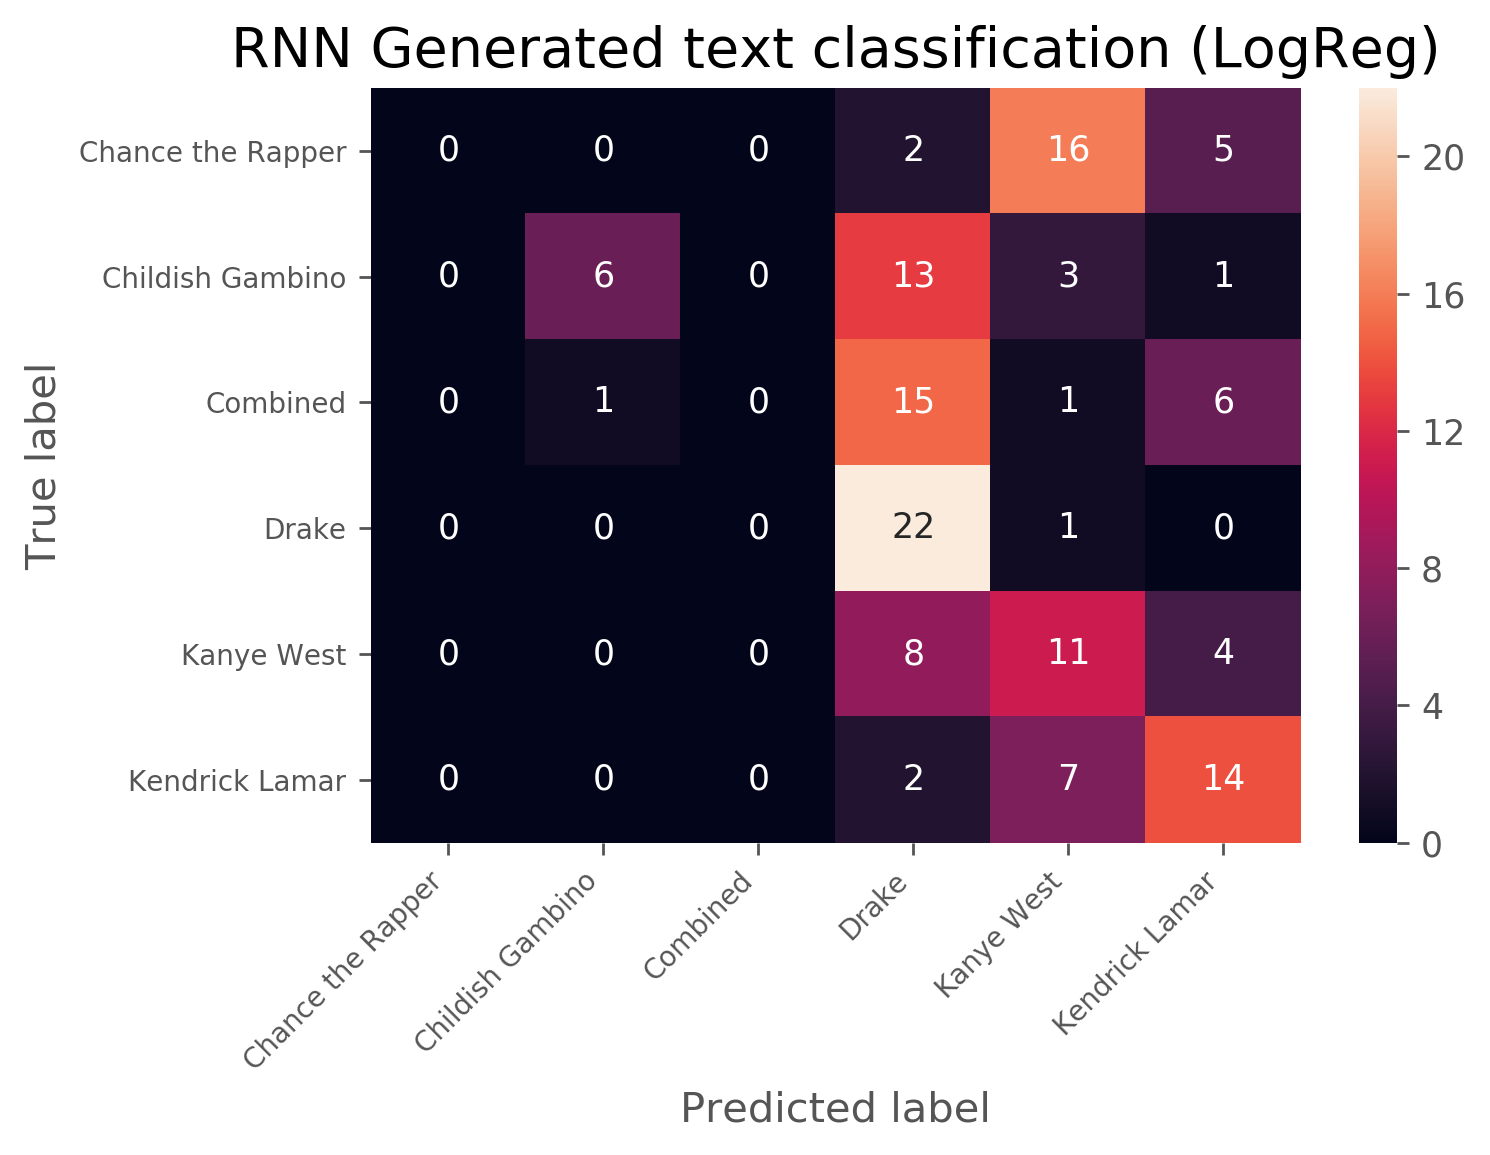

In [224]:
model = lm1

predict_y_test = model.predict(x_test)

RF = confusion_matrix(y_test, predict_y_test)
RF_CM = print_confusion_matrix_rnn(RF, ['Chance the Rapper', 'Childish Gambino', 'Combined', 'Drake', 'Kanye West', 'Kendrick Lamar'])

In [184]:
y_test

0      Kendrick Lamar
1      Kendrick Lamar
2      Kendrick Lamar
3      Kendrick Lamar
4      Kendrick Lamar
5      Kendrick Lamar
6      Kendrick Lamar
7      Kendrick Lamar
8      Kendrick Lamar
9      Kendrick Lamar
10     Kendrick Lamar
11     Kendrick Lamar
12     Kendrick Lamar
13     Kendrick Lamar
14     Kendrick Lamar
15     Kendrick Lamar
16     Kendrick Lamar
17     Kendrick Lamar
18     Kendrick Lamar
19     Kendrick Lamar
20     Kendrick Lamar
21     Kendrick Lamar
22     Kendrick Lamar
23           Combined
24           Combined
25           Combined
26           Combined
27           Combined
28           Combined
29           Combined
            ...      
108             Drake
109             Drake
110             Drake
111             Drake
112             Drake
113             Drake
114             Drake
115        Kanye West
116        Kanye West
117        Kanye West
118        Kanye West
119        Kanye West
120        Kanye West
121        Kanye West
122       

In [190]:
result = list(zip(y_test, predict_y_test))

for i in result:
    if i[0] == 'Combined':
        print(i)

('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Childish Gambino')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Kendrick Lamar')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Kendrick Lamar')
('Combined', 'Kendrick Lamar')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Drake')
('Combined', 'Kanye West')
('Combined', 'Drake')
('Combined', 'Kendrick Lamar')
('Combined', 'Kendrick Lamar')
('Combined', 'Kendrick Lamar')


In [191]:
result = list(zip(y_test, predict_y_test))

for i in result:
    if i[0] == 'Drake':
        print(i)

('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Kanye West')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')
('Drake', 'Drake')


In [192]:
result = list(zip(y_test, predict_y_test))

for i in result:
    if i[0] == 'Childish Gambino':
        print(i)

('Childish Gambino', 'Childish Gambino')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Childish Gambino')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Kanye West')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Childish Gambino')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Childish Gambino')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Kanye West')
('Childish Gambino', 'Kendrick Lamar')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Childish Gambino')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Childish Gambino')
('Childish Gambino', 'Drake')
('Childish Gambino', 'Kanye West')
('Childish Gambino', 'Drake')


In [194]:
result = list(zip(y_test, predict_y_test))

for i in result:
    if i[0] == 'Kanye West':
        print(i)

('Kanye West', 'Drake')
('Kanye West', 'Kanye West')
('Kanye West', 'Drake')
('Kanye West', 'Kanye West')
('Kanye West', 'Kendrick Lamar')
('Kanye West', 'Drake')
('Kanye West', 'Drake')
('Kanye West', 'Kanye West')
('Kanye West', 'Kanye West')
('Kanye West', 'Kanye West')
('Kanye West', 'Drake')
('Kanye West', 'Kanye West')
('Kanye West', 'Kanye West')
('Kanye West', 'Kendrick Lamar')
('Kanye West', 'Kanye West')
('Kanye West', 'Kendrick Lamar')
('Kanye West', 'Drake')
('Kanye West', 'Kanye West')
('Kanye West', 'Kanye West')
('Kanye West', 'Drake')
('Kanye West', 'Drake')
('Kanye West', 'Kendrick Lamar')
('Kanye West', 'Kanye West')


In [195]:
result = list(zip(y_test, predict_y_test))

for i in result:
    if i[0] == 'Chance the Rapper':
        print(i)

('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kendrick Lamar')
('Chance the Rapper', 'Drake')
('Chance the Rapper', 'Kendrick Lamar')
('Chance the Rapper', 'Kendrick Lamar')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Drake')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kendrick Lamar')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kendrick Lamar')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')
('Chance the Rapper', 'Kanye West')


## classify using markov generated verses

In [227]:
with open('data/kendrick_markov_raps.pkl', 'rb') as picklefile:
    kendrick_markov_df = pickle.load(picklefile)
    
with open('data/all_rappers_markov_raps.pkl', 'rb') as picklefile:
    all_rappers_markov_df = pickle.load(picklefile)
    
with open('data/childish_markov_raps.pkl', 'rb') as picklefile:
    childish_markov_df = pickle.load(picklefile)
    
with open('data/chance_markov_raps.pkl', 'rb') as picklefile:
    chance_markov_df = pickle.load(picklefile)
    
with open('data/drake_markov_raps.pkl', 'rb') as picklefile:
    drake_markov_df = pickle.load(picklefile)
    
with open('data/kanye_markov_raps.pkl', 'rb') as picklefile:
    kanye_markov_df = pickle.load(picklefile)

In [228]:
frames = [kendrick_markov_df, all_rappers_markov_df, childish_markov_df, chance_markov_df,
          drake_markov_df, kanye_markov_df]

markov_verses_df = pd.concat(frames)

markov_verses_df.reset_index(inplace=True)

In [230]:
markov_verses_df.artist.value_counts()

Childish Gambino     100
Chance the Rapper    100
Combined             100
Drake                100
Kanye West           100
Kendrick Lamar       100
Name: artist, dtype: int64

In [231]:
markov_verses_df

index                            markov_generated_verses          artist
0        0  blue but if i kill them with collision kings d...  Kendrick Lamar
1        1  people know just what you doin just make it to...  Kendrick Lamar
2        2  brother cry i got a swimming pool left stroke ...  Kendrick Lamar
3        3  bitch i woke up in weeks and i run at ho with ...  Kendrick Lamar
4        4  apple jacks and after that i m in it record tw...  Kendrick Lamar
5        5  friends so he did a lot bout each other wrong ...  Kendrick Lamar
6        6  blue faces get that new money and power respec...  Kendrick Lamar
7        7  love speed up breed up or speed up dont you as...  Kendrick Lamar
8        8  blue pill then feel free my mind or die from n...  Kendrick Lamar
9        9  blue pill and remy red come through flow sicke...  Kendrick Lamar
10      10  apple software got the love of money and freed...  Kendrick Lamar
11      11  brother nigga d3 is from an industry nigga the...  Kendrick Lamar
12      12  brother if the iraqis w was in the hospital wi...  Kendrick Lamar
13      13  cap we hit the fan never on vacation start up ...  Kendrick Lamar
14      14  red like diddy pop off then i hopefully abused...  Kendrick Lamar
15      15  guns drawn bang motherfucker bang one chopper ...  Kendrick Lamar
16      16  blue bell jeans on low cut taper no i m riding...  Kendrick Lamar
17      17  red light minutes from midnight with no licens...  Kendrick Lamar
18      18  drugs and i m talking eliminating everyone inc...  Kendrick Lamar
19      19  friends so many motherfuckers wanna down me an...  Kendrick Lamar
20      20  blue faces she said so what we cant see the fe...  Kendrick Lamar
21      21  cap peeled off in that water and running on wa...  Kendrick Lamar
22      22  bitch dont remember what winter did i stutter ...  Kendrick Lamar
23      23  cash my foundation was but now im grown up can...  Kendrick Lamar
24      24  liquor then motherfucker you better guard your...  Kendrick Lamar
25      25  cap salary come a long time dont you see right...  Kendrick Lamar
26      26  liquor and grade a cop on the top like a mad c...  Kendrick Lamar
27      27  brother if i go through i told you i killed hi...  Kendrick Lamar
28      28  liquor imma burn this that i might slap the sh...  Kendrick Lamar
29      29  guns to my senses you never can stride into co...  Kendrick Lamar
..     ...                                                ...             ...
570     70  blue called it just a lil bit i think the gras...      Kanye West
571     71  club when you were suckin a nigga ass it was m...      Kanye West
572     72  bitch you had a stove but its blurry enough to...      Kanye West
573     73  red top of my own career i m letting everythin...      Kanye West
574     74  bitch i no other help i know its just may nigg...      Kanye West
575     75  brother gon pull through we gon do it my way h...      Kanye West
576     76  people you know thats nothing new stop everyth...      Kanye West
577     77  red toupee on the phone why do i mean after al...      Kanye West
578     78  drugs are you my favorite toy cause it all it ...      Kanye West
579     79  liquor store ah and we be the pimp and prince ...      Kanye West
580     80  streets kinda hard to believe in equality of r...      Kanye West
581     81  apple steve jobs has left as starts steve jobs...      Kanye West
582     82  cap drop top porsche spoil yourself thats impo...      Kanye West
583     83  people lookin at a club and get some leeway on...      Kanye West
584     84  drugs for my soul rosewood we could see her fa...      Kanye West
585     85  love made me everything i am limelight bluepri...      Kanye West
586     86  apple it so hot you can still smell the sweat ...      Kanye West
587     87  streets player man at least two a m and i ende...      Kanye West
588     88                              streets im on the map      Kanye West
589     89  bitch got to sa

In [233]:
x_test = markov_verses_df.markov_generated_verses
y_test = markov_verses_df.artist

In [234]:
##TEST MODELS ON markov GENERATED DATA

models = [lm1, rf1, knn1, dc, knn2, dt1, rf2, dt2]
names = ['LogReg', 'Random Forest', 'KNN', 'Dummy', 'KNN2', 'Decision Tree', 'RF2', 'DT2']

print(f'TEST Scores ALL RAPPERS')

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []

    y_predict = model.predict(x_test)

    accuracy.append(accuracy_score(y_test, y_predict))
    precision.append(precision_score(y_test, y_predict, average=None))
    recall.append(recall_score(y_test, y_predict, average=None))
    f1.append(f1_score(y_test, y_predict, average=None))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)


    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

TEST Scores ALL RAPPERS
LogReg accuracy: 0.2633 precision: 0.3762 recall: 0.2633 f1: 0.1973

Random Forest accuracy: 0.2583 precision: 0.3821 recall: 0.2583 f1: 0.1794

KNN accuracy: 0.2233 precision: 0.1978 recall: 0.2233 f1: 0.2045

Dummy accuracy: 0.1483 precision: 0.1186 recall: 0.1483 f1: 0.1257

KNN2 accuracy: 0.2217 precision: 0.1922 recall: 0.2217 f1: 0.2036

Decision Tree accuracy: 0.2033 precision: 0.1449 recall: 0.2033 f1: 0.1559

RF2 accuracy: 0.2183 precision: 0.1814 recall: 0.2183 f1: 0.1814

DT2 accuracy: 0.1733 precision: 0.151 recall: 0.1733 f1: 0.1496



In [237]:
def print_confusion_matrix_markov(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(dpi=250)
    plt.title("Markov Generated text classification (LogReg)", fontsize=16)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig('/Users/brendenrossin/github/Project_Fletcher/markov_generated_cm.png', format='png', dpi=1000, bbox_inches="tight")
    return fig

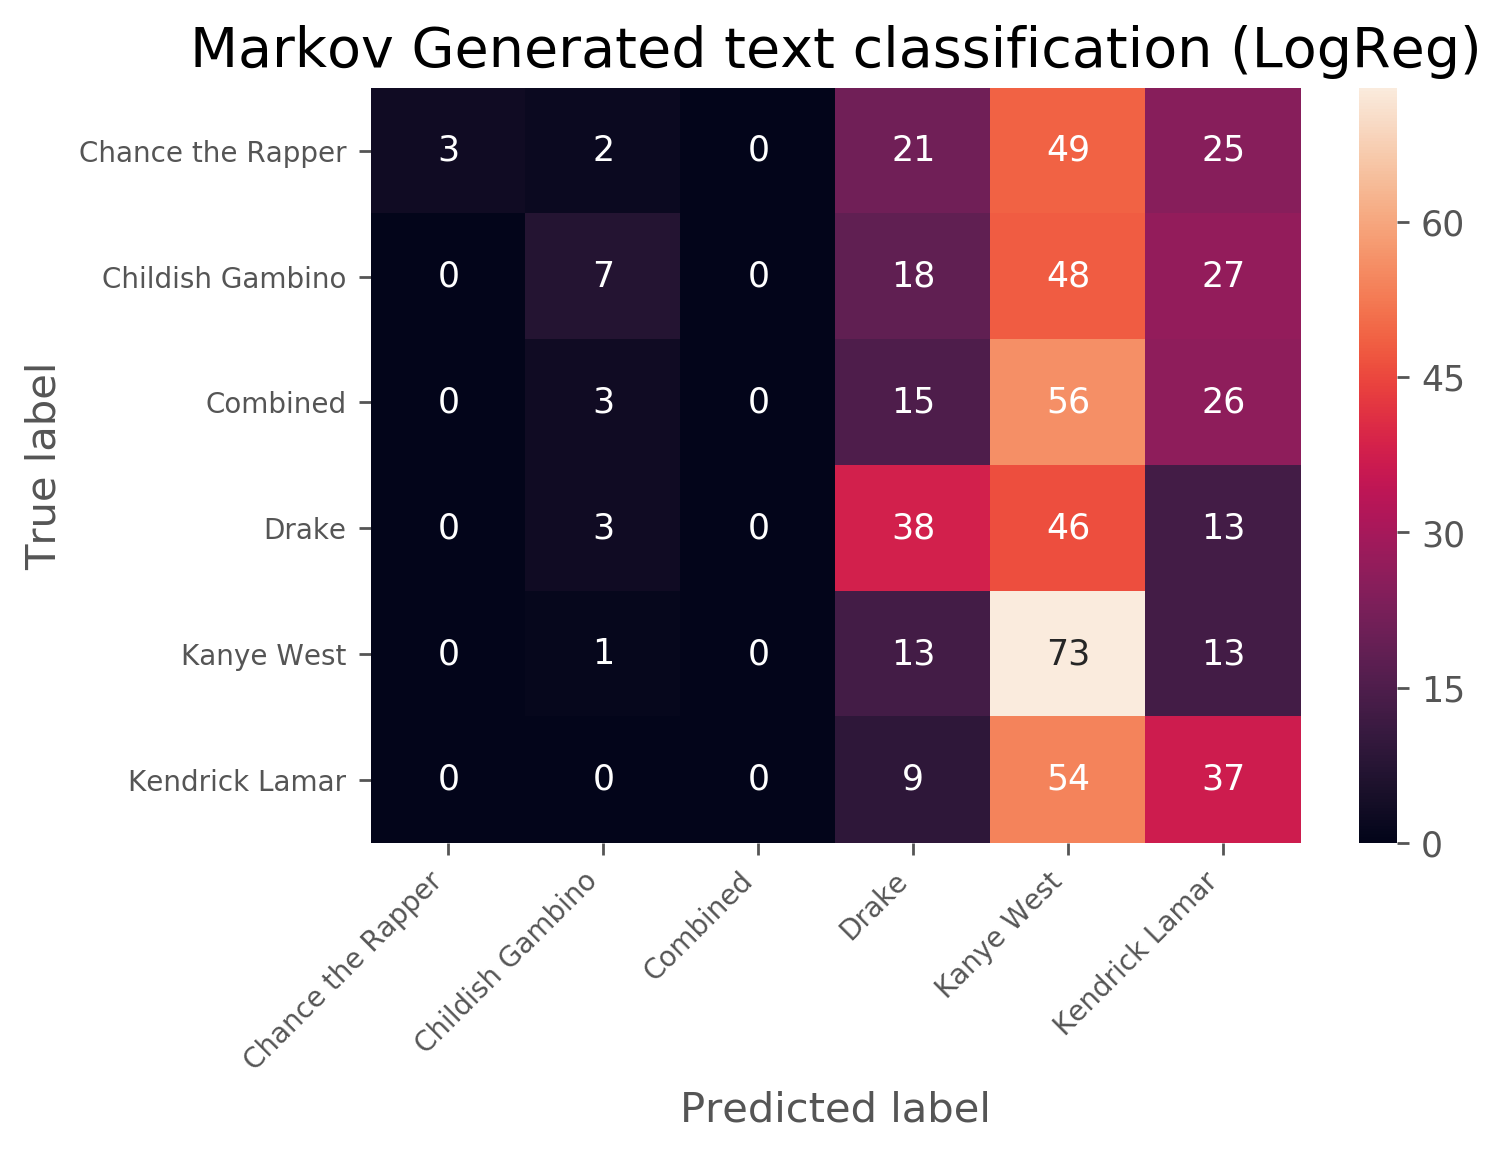

In [238]:
model = lm1

predict_y_test = model.predict(x_test)

RF = confusion_matrix(y_test, predict_y_test)
RF_CM = print_confusion_matrix_markov(RF, ['Chance the Rapper', 'Childish Gambino', 'Combined', 'Drake', 'Kanye West', 'Kendrick Lamar'])